In [1]:
import os
import sys
import math
import numpy as np
import env, plotting, utils, queue


class Node:
    def __init__(self, n):
        self.x = n[0]
        self.y = n[1]
        self.parent = None
        
    def print_node_chain(self, node=None, counter=0, show_parents=True):
        
        if node is None:
            node = self
                
        print("Node " + str(counter) + ": ")
        print("x: ", node.x)
        print("y: ", node.y)
        
        if node.parent is None:
            print("parent: None")  
            print("---------------------------------")
        else:
            print("parent: (" + str(node.parent.x) + ", " + str(node.parent.y) + ")")
        print("---------------------------------")
        
        if show_parents:
            counter += 1
            if node.parent is not None:
                node.print_node_chain(node=node.parent, counter=counter)


class RrtStar:
    def __init__(self, x_start, x_goal, step_len, goal_sample_rate, search_radius, iter_max, max_turn_angle = np.deg2rad(14)):
        
        self.s_start = Node(x_start) #start
        self.s_goal = Node(x_goal) #goal
        self.goal_sample_rate = goal_sample_rate #number of nodes randomly sampled at each iterations
        self.search_radius = search_radius #radius to find nearest neighnbor
        self.iter_max = iter_max
        self.vertex = [self.s_start]
        self.path = []
        self.path_vertex = []

        self.plotting = plotting.Plotting(x_start, x_goal)
        self.utils = utils.Utils()


        #-----------------------------------------------------
        #Set up environment
        self.env = env.Env()
        
        self.margin = 0.5
        
        # Find minimum and maximum x coordinates with margin
        min_x = min( self.s_start.x, self.s_goal.x ) - self.margin
        max_x = max( self.s_start.x, self.s_goal.x ) + self.margin
        
        # Find minimum and maximum y coordinates with margin
        min_y = min( self.s_start.y, self.s_goal.y ) - self.margin
        max_y = max( self.s_start.y, self.s_goal.y ) + self.margin
        
        # Define bounding box ranges
        self.x_range = (min_x, max_x)
        self.y_range = (min_y, max_y)
        
        # self.x_range = self.env.x_range #(0, 50)
        # self.y_range = self.env.y_range #(0, 30)
        self.obs_circle = self.env.obs_circle
        self.obs_rectangle = self.env.obs_rectangle
        self.obs_boundary = self.env.obs_boundary
        
        #-----------------------------------------------------
        
        self.goal_radius = 0.08
        
        #For Digit Constraints:
        self.max_turn_ang = max_turn_angle
        self.step_len_max = 0.3
        self.step_len_min = 0.1
        
        self.step_len = min(step_len, self.step_len_max) #step length

    def plan(self, heading_c=0, obstacle_margin=None):
        '''
        TODO
        self.utils.is_collision()
            - implement a way to add new obstacles into the map
            - check for high uncertainty in the terrain / infeasible height change
        '''
        
        if obstacle_margin is None:
            obstacle_margin = self.utils.delta
            
        temp = self.max_turn_ang
        
        for k in range(self.iter_max):
            
            if k < 25:
                self.max_turn_ang = np.deg2rad(5)
            else:
                self.max_turn_ang = temp

            node_rand = self.generate_random_node(self.goal_sample_rate)
            node_near = self.nearest_neighbor(self.vertex, node_rand) #find the closest tree node to the sampled point
            # node_new = self.new_state(node_near, node_rand) #move the nearest tree node in the direction toward the sample point, but limited to the maximum step_len 
                                                            #(the nearest tree node will be the parent of the new node)
            admissible_node_list = self.branch_all_feasible_nodes(node_near, heading_default=heading_c)
            
            if k % 500 == 0:
                print(k)
            
            for node_new in admissible_node_list:
                
                #Check if path from nearet tree node to the new node is safe
                if node_new and not self.utils.is_collision(node_near, node_new, delta=obstacle_margin):
                    # neighbor_index = self.find_near_neighbor(node_new) #find other neighbor node near the new node
                    self.vertex.append(node_new) #append new node to the vertex

                    # if neighbor_index:
                    #     self.choose_parent(node_new, neighbor_index) #reassign the parent of the new node, if there are closer neighbor
                    #     self.rewire(node_new, neighbor_index) #if new node is closer to the start than neighbor, make the new node a parent of that neighbor
                        
                #if reach within 2m radius of the goal position, end the tree search
                if math.hypot(node_new.x - self.s_goal.x, node_new.y - self.s_goal.y) <= self.goal_radius:
                    break
                
            else:
                continue
            break #break outer for-loop when within goal radius
                    
        index = self.search_goal_parent()
        self.path, self.path_vertex = self.extract_path(self.vertex[index])
        self.k = k
        self.path_vertex.pop(-1)
        self.get_interpolant_param() #generate self.m_list and self.c_list
                
        for i in np.flip(np.arange(0, len(self.path_vertex) - 1)):
            self.rewire_path(s_start_index=i)
        
    
    def rewire_path(self, s_start_index):   
        
        #Rewiring
        i = s_start_index
        
        
        if i > 0:
            _ , heading_c  = self.get_distance_and_angle(self.path_vertex[s_start_index - 1], self.path_vertex[s_start_index])
        else:
            heading_c = 0
        
        for path_node_index in np.arange(s_start_index + 1, len(self.path_vertex) - 1): 
            
            #Two step planning, make sure turning angles are valid for two forward steps
            dist , heading_n  = self.get_distance_and_angle(self.path_vertex[s_start_index], self.path_vertex[path_node_index])
            _ , heading_nn  = self.get_distance_and_angle(self.path_vertex[path_node_index], self.path_vertex[path_node_index + 1])

            
            if (abs(heading_n - heading_c) <= self.max_turn_ang) and (abs(heading_nn - heading_n) <= self.max_turn_ang) and \
                not self.utils.is_collision(self.path_vertex[s_start_index], self.path_vertex[path_node_index]):
                
                i = path_node_index
                
        if i > s_start_index:
            #if valid nodes found, set it as the child of new starting point
            if dist <= self.step_len:
                self.path_vertex[i].parent = self.path_vertex[s_start_index]
            else:
                self.add_interpolated_parents(self.path_vertex[s_start_index], self.path_vertex[i])
            
            #Save replanned path
            index = self.search_goal_parent()
            self.path, self.path_vertex = self.extract_path(self.vertex[index])
            self.path_vertex.pop(-1)
            self.get_interpolant_param() #generate self.m_list and self.c_list
            
        
        if i == s_start_index or i == len(self.path_vertex) - 2:
            return
        else:
            self.rewire_path(s_start_index=i)
        
    def replan(self, s_start_new, heading_c=0, recursive_count = 0, obstacle_margin=None):
        '''
        Search for closest nodes in the existing path to merge with the new starting point
        '''
        
        #TODO: New strategy -> find the nearest node in the path, find the heading of the next node, plan from new start node to that node
        
        if recursive_count > 100:
            raise MemoryError ("Replanning Failed. Too much iterations.")
        recursive_count += 1
        
        if not isinstance(s_start_new, Node):
            if isinstance(s_start_new, tuple):
                s_start_new = Node(s_start_new) 
                self.vertex.append(s_start_new)  
            else:
                raise TypeError ("Value must be an instance of tuple or Node class")
        
        if obstacle_margin is None:
            obstacle_margin = self.utils.delta
        
        if self.utils.is_inside_obs(s_start_new, delta=obstacle_margin):
            if recursive_count < 2:
                raise ValueError ("Cannot start at a node where there is an obstacle.")
        
        #Get index of the starting node     
        s_start_index = self.vertex.index(s_start_new)
        self.vertex[s_start_index].print_node_chain(show_parents=False) #Print the node
        
        if math.hypot(self.vertex[s_start_index].x - self.s_goal.x, self.vertex[s_start_index].y - self.s_goal.y) <= self.goal_radius:
            #Save replanned path
            index = self.search_goal_parent()
            self.path, self.path_vertex = self.extract_path(self.vertex[index])
            self.path_vertex.pop(-1)
            return
        
        
        #--------------- Quick Check: drawing straight line to any node in the optimal path -----------------------
        
        # for path_node in self.path_vertex:
        #     dist, heading_n = self.get_distance_and_angle(self.vertex[s_start_index], path_node)
        #     num_steps = int(dist/self.step_len)
        #     num_turns = int((heading_n - heading_c)/self.max_turn_ang)
            
        #     if not self.utils.is_collision(self.vertex[s_start_index], path_node) and abs(heading_n - heading_c):
        #         if dist <= self.step_len:
        #             path_node.parent = self.vertex[s_start_index]
        #         else:
        #             self.add_interpolated_parents(self.vertex[s_start_index], path_node)
                
        #         #Save replanned path
        #         index_goal = self.search_goal_parent()
        #         self.path, _ = self.extract_path(self.vertex[index_goal])
        #         return
                
            
        # print("Quick Planning Failed, try to rebranch the start node.")
        
        #---------------- Branch out the start node and continue ----------------------------
        # lcv = 0
        # while lcv < 300:
            
        #     self.vertex[s_start_index].print_node_chain(show_parents=False) #Print to check
            
        #     #initialize cost
        #     minimum_cost = 100
                        
        #     #all feasible nodes branched out from the new starting point
        #     admissible_node_list = self.branch_all_feasible_nodes(self.vertex[s_start_index])      
            
        #     for node_new in admissible_node_list:
        #         #Check for collision
        #         if node_new and not self.utils.is_collision(self.vertex[s_start_index], node_new):
                    
        #             #First step replanning
        #             _ , heading_n  = self.get_distance_and_angle(self.vertex[s_start_index], node_new)
                    
        #             #find other neighbor node near the new node
        #             neighbor_index = self.find_near_neighbor(node_new) 
        #             self.vertex.append(node_new) #append new node to the vertex
                    
        #             for index in neighbor_index:
                        
        #                 #Second step replanning
        #                 dist , heading_nn  = self.get_distance_and_angle(node_new, self.vertex[index])
                        
        #                 #if valid nodes found, set it as the child of new starting point
        #                 if abs(heading_nn - heading_n) <= self.max_turn_ang:
                            
        #                     #is the neightbor of the new node a part of optimal trajectory?
        #                     if self.is_near_optimal_path(index, heading_nn):
                                
        #                         if dist <= self.step_len:
        #                             self.vertex[index].parent = node_new
        #                         else:
        #                             self.add_interpolated_parents(node_new, self.vertex[index])
                                
        #                         #Save replanned path
        #                         index_goal = self.search_goal_parent()
        #                         self.path, _ = self.extract_path(self.vertex[index_goal])
        #                         return
                                                        
        #             #check cost of the new node to see how close it is to the optimal path
        #             cost = [self.get_new_cost(node_new, path_node, heading_default=heading_n) for path_node in self.path_vertex]
        #             if min(cost) < minimum_cost:
        #                 #Set the lowest cost node as the new staring point
        #                 minimum_cost = min(cost)
        #                 s_start_index = len(self.vertex) - 1
                        
        #     lcv += 1
            
        # print("Replanning Failed.")
            
        # #Worst Case: replan the entire tree branch
        # self.path = []
        # self.path_vertex = []
        # self.vertex = [s_start_new]
        # self.plan(heading_c=heading_c)
        # return
                        
                    
                    
        
        #--------------------------------------------

        #Comparing the cost of getting from starting node to the current optimal path
        cost = [self.get_new_cost(self.vertex[s_start_index], path_node, heading_default=heading_c) for path_node in self.path_vertex]
        # cost.append(self.get_new_cost(self.vertex[s_start_index], self.s_goal, heading_default=heading_c))
        
        low_cost_count = sum(1 for c in cost if c < 50) #High cost means it violates maximum turning angle
        
        #Sort for lowest cost that only has admissable turning angle
        sorted_cost_indices = sorted(range(len(cost)), key=lambda i: cost[i])
        cost_min_indices = sorted_cost_indices[:low_cost_count]
        
        for cost_min_index in cost_min_indices: 
            
            #Two step planning, make sure turning angles are valid for two forward steps
            dist , heading_n  = self.get_distance_and_angle(self.vertex[s_start_index], self.path_vertex[cost_min_index])
            
            if cost_min_index < len(self.path_vertex) - 1:
                _ , heading_nn  = self.get_distance_and_angle(self.path_vertex[cost_min_index], self.path_vertex[cost_min_index + 1])
            else:
                heading_nn = heading_n
            
            if (abs(heading_n - heading_c) <= self.max_turn_ang) and (abs(heading_nn - heading_n) <= self.max_turn_ang) and \
                not self.utils.is_collision(self.vertex[s_start_index], self.path_vertex[cost_min_index], delta=obstacle_margin):
                
                #if valid nodes found, set it as the child of new starting point
                if dist <= self.step_len:
                    self.path_vertex[cost_min_index].parent = self.vertex[s_start_index]
                else:
                    self.add_interpolated_parents(self.vertex[s_start_index], self.path_vertex[cost_min_index])
                
                #Save replanned path
                index = self.search_goal_parent()
                self.path, self.path_vertex = self.extract_path(self.vertex[index])
                self.path_vertex.pop(-1)
                self.get_interpolant_param() #generate self.m_list and self.c_list
                return
        
        #--------------------------------------------
        
        print("Check if the start node overlaps the path")
        
        #Check for smallest distance to path, in order to determine the step length
        nearest_node_index = int(np.argmin([math.hypot(nd.x - self.vertex[s_start_index].x, nd.y - self.vertex[s_start_index].y) for nd in self.path_vertex]))
        
        step_l , angle = self.find_intercept_path(self.vertex[s_start_index], heading_c, nearest_node_index)
        
        if step_l ==  0 and angle == 0:
            self.path_vertex[nearest_node_index + 1].parent = self.vertex[s_start_index]
            
            #Save replanned path
            index = self.search_goal_parent()
            self.path, self.path_vertex = self.extract_path(self.vertex[index])
            self.path_vertex.pop(-1)
            self.get_interpolant_param() #generate self.m_list and self.c_list
            return
            
        elif step_l is not None:
            node_new = Node((self.vertex[s_start_index].x + step_l * np.cos(angle), self.vertex[s_start_index].y + step_l * np.sin(angle)))
            node_new.parent = self.vertex[s_start_index]
            self.vertex.append(node_new)
            self.path_vertex[nearest_node_index + 1].parent = node_new
            
            # print("node new chain")
            # node_new.print_node_chain()
                
            #Save replanned path
            index = self.search_goal_parent()
            self.path, self.path_vertex = self.extract_path(self.vertex[index])
            self.path_vertex.pop(-1)
            self.get_interpolant_param() #generate self.m_list and self.c_list
            return
            
        #--------------------------------------------
            
        print("Branching out the start node!")
                
        admissible_node_list = self.branch_all_feasible_nodes(self.vertex[s_start_index], heading_default=heading_c)
        minimum_cost = 100
        closest_node_index = s_start_index
        closest_node_heading = heading_c
        
        for node_new in admissible_node_list:
            if not self.utils.is_collision(self.vertex[s_start_index], node_new, delta=obstacle_margin):
                _ , heading_node_new  = self.get_distance_and_angle(self.vertex[s_start_index], node_new)
                self.vertex.append(node_new)
                
                #branch out the start node, and find the nearest one to the optimal path
                cost = [self.get_new_cost(node_new, path_node, heading_default=heading_node_new) for path_node in self.path_vertex]
                                
                if min(cost) < minimum_cost:
                    #Set the lowest cost node as the new staring point
                    minimum_cost = min(cost)
                    closest_node_index = len(self.vertex) - 1 #last index, since it is recently appended to the tree
                    closest_node_heading = heading_node_new
                
        #Keep replanning with new node that is nearest to the optimal path
        self.replan(self.vertex[closest_node_index], heading_c=closest_node_heading, recursive_count=recursive_count)
    
    
    
    def find_intercept_path(self, current_node, heading_c, nearest_node_index, eps = 0.015):
        
        if nearest_node_index  < len(self.path_vertex) - 1:
            m1 = self.m_list[nearest_node_index]
            c1 = self.c_list[nearest_node_index]
            
            
            _, heading_n = self.get_distance_and_angle(self.path_vertex[nearest_node_index], self.path_vertex[nearest_node_index + 1])
            if abs(m1*current_node.x + c1 - current_node.y) < eps and abs(heading_n - heading_c) <= self.max_turn_ang:
                print("new node is right on the path")
                return 0, 0
            
            for angle in np.linspace(heading_c - self.max_turn_ang, heading_c + self.max_turn_ang, 7):
                for step_l in np.linspace(self.step_len_min, self.step_len_max, 5):
                    
                    #branch current node
                    branch_node = (current_node.x + step_l * np.cos(angle), current_node.y + step_l * np.sin(angle))
                    
                    if abs(m1*branch_node[0] + c1 - branch_node[1]) < eps and abs(heading_n - angle) <= self.max_turn_ang:
                        print("new node can branch out and join the path")
                        return step_l, angle
                          
        return None, None
                    
            
            
        
        
    def add_interpolated_parents(self, parent_node, child_node, step_length=None):
        
        if step_length is None:
            step_length = self.step_len
        
        parent_index = self.vertex.index(parent_node)
        last_child_index = self.vertex.index(child_node)
        
        # Calculate the distance between the two points
        dist, _ = self.get_distance_and_angle(parent_node, child_node)
        
        # Calculate the number of steps needed
        num_steps = int(dist / step_length)
        
        if num_steps > 1:
            # Calculate the step size in each dimension
            step_x = (child_node.x - parent_node.x) / num_steps
            step_y = (child_node.y - parent_node.y) / num_steps
            
            # Interpolated Nodes
            for i in range(num_steps):
                if i == 0:
                    continue
                
                new_x = parent_node.x + i * step_x
                new_y = parent_node.y + i * step_y
                
                interp_node = Node((new_x, new_y))
                interp_node.parent = self.vertex[parent_index]
                
                self.vertex.append(interp_node)
                parent_index = self.vertex.index(interp_node)
                
                
        self.vertex[last_child_index].parent = self.vertex[parent_index]
        
    def get_interpolant_param(self, eps=0.00001):
    
        path = np.array(self.path)
        x = path[:len(path) - 1,0]
        y = path[:len(path) - 1,1]

        self.m_list = np.zeros(len(x)-1)
        self.c_list = np.zeros(len(x)-1)

        for i in range(len(x)-1):
            
            den = (x[i+1]-x[i])
            
            if den == 0:
                den = eps
            
            m = (y[i+1]-y[i])/den
            c1 = (y[i]-m*x[i])
            c2 = (y[i+1]-m*x[i+1])

            # print("For (%.1f, %.1f) and (%.1f, %.1f), m = %.2f and c1 = %.2f, c2 = %.2f."
            #          % (x[i], y[i], x[i+1], y[i+1], m, c1, c2))
            
            self.m_list[i] = m
            self.c_list[i] = c1
        

                        #node_near, node_rand
    def new_state(self, node_start, node_goal):
        dist, theta = self.get_distance_and_angle(node_start, node_goal)
        
        #Define current heading
        if self.is_start_node(node_start) or node_start.parent is None:
            heading_c = 0
        else:
            _, heading_c = self.get_distance_and_angle(node_start.parent, node_start)
            
        #Check if the heading chnage is feasible
        if abs(theta - heading_c) > self.max_turn_ang:
            return None

        #Else branch out the tree node that has feasible turning angle
        dist = min(self.step_len, dist)
        node_new = Node((node_start.x + dist * math.cos(theta),
                         node_start.y + dist * math.sin(theta)))

        node_new.parent = node_start

        return node_new
    
    def branch_all_feasible_nodes(self, node_start, heading_default=0):
        
        #Define current position
        x = node_start.x
        y = node_start.y
        
        #Define current heading
        if self.is_start_node(node_start) or node_start.parent is None:
            heading_c = heading_default
        else:
            _, heading_c = self.get_distance_and_angle(node_start.parent, node_start)
            
        #Branch the tree node_start to all possible feasible nodes        
        valid_neighbors = []

        for angle in np.linspace(heading_c - self.max_turn_ang, heading_c + self.max_turn_ang, 7):
            # for step_l in np.linspace(self.step_l_min, self.step_l_max, 3):
            admiss_neighbor = Node((x + self.step_len * np.cos(angle), y + self.step_len * np.sin(angle)))
            admiss_neighbor.parent = node_start
            valid_neighbors.append(admiss_neighbor)

        return valid_neighbors

    def choose_parent(self, node_new, neighbor_index):
        cost = [self.get_new_cost(self.vertex[i], node_new) for i in neighbor_index]
        
        cost_min_index = neighbor_index[int(np.argmin(cost))]
        node_new.parent = self.vertex[cost_min_index]

    def rewire(self, node_new, neighbor_index):
        for i in neighbor_index:
            node_neighbor = self.vertex[i]

            #Define current heading
            if self.is_start_node(node_new) or node_new.parent is None:
                heading_c = 0
            else:
                _, heading_c = self.get_distance_and_angle(node_new.parent, node_new)
            
            #Define new heading if node_new was the parent of the neighbor 
            _, new_heading = self.get_distance_and_angle(node_new, node_neighbor)
            
             #if the cost of the getting to the neighbor > the cost of getting to the new node then to the neighbor,
            #reassign the new node as the parent of the neighbor
            if self.cost(node_neighbor) > self.get_new_cost(node_new, node_neighbor) and (abs(new_heading - heading_c) <= self.max_turn_ang):
                node_neighbor.parent = node_new

    def search_goal_parent(self):
        dist_list = [math.hypot(n.x - self.s_goal.x, n.y - self.s_goal.y) for n in self.vertex]
        node_index = [i for i in range(len(dist_list)) if dist_list[i] <= self.goal_radius] #<= self.step_len

        if len(node_index) > 0:
            cost_list = [dist_list[i] + self.cost(self.vertex[i]) for i in node_index
                            if not self.utils.is_collision(self.vertex[i], self.s_goal)]
            return node_index[int(np.argmin(cost_list))]

        return len(self.vertex) - 1

    def get_new_cost(self, node_start, node_end, heading_default = 0):
        
        #original cost
        dist, heading_n = self.get_distance_and_angle(node_start, node_end)
        
        #Define current heading
        if self.is_start_node(node_start) or node_start.parent is None:
            heading_c = heading_default
        else:
            _, heading_c = self.get_distance_and_angle(node_start.parent, node_start)
        
        #Increase cost for violating the turning angle
        if abs(heading_n - heading_c) > self.max_turn_ang:
            turn_penalty = 50
        else:
            turn_penalty = 0

        return self.cost(node_start) + dist + turn_penalty

    def generate_random_node(self, goal_sample_rate):
        delta = self.utils.delta #0.5 as of now

        if np.random.random() > goal_sample_rate: #10% chance of not generating any new nodes
            return Node((np.random.uniform(self.x_range[0] + delta, self.x_range[1] - delta),
                         np.random.uniform(self.y_range[0] + delta, self.y_range[1] - delta)))

        return self.s_goal #return goal instead

    def find_near_neighbor(self, node_new):
        n = len(self.vertex) + 1
        r = min(self.search_radius * math.sqrt((math.log(n) / n)), self.step_len)

        dist_table = [math.hypot(nd.x - node_new.x, nd.y - node_new.y) for nd in self.vertex]
        dist_table_index = [ind for ind in range(len(dist_table)) if dist_table[ind] <= r and
                            not self.utils.is_collision(node_new, self.vertex[ind])]

        return dist_table_index

    @staticmethod
    def nearest_neighbor(node_list, n):
        return node_list[int(np.argmin([math.hypot(nd.x - n.x, nd.y - n.y)
                                        for nd in node_list]))]

    @staticmethod
    def cost(node_p):
        node = node_p
        cost = 0.0

        while node.parent:
            cost += math.hypot(node.x - node.parent.x, node.y - node.parent.y)
            node = node.parent

        return cost

    def update_cost(self, parent_node):
        OPEN = queue.QueueFIFO()
        OPEN.put(parent_node)

        while not OPEN.empty():
            node = OPEN.get()

            if len(node.child) == 0:
                continue

            for node_c in node.child:
                node_c.Cost = self.get_new_cost(node, node_c)
                OPEN.put(node_c)

    def extract_path(self, node_end):
        path = [[self.s_goal.x, self.s_goal.y]]
        path_vertex = [self.s_goal]
        
        node = node_end

        while node.parent is not None:
            path.append([node.x, node.y])
            path_vertex.append(node)
            
            node = node.parent
            
        path.append([node.x, node.y])
        path_vertex.append(node)
        

        return list(reversed(path)), list(reversed(path_vertex))

    @staticmethod
    def get_distance_and_angle(node_start, node_end):
        dx = node_end.x - node_start.x
        dy = node_end.y - node_start.y
        return math.hypot(dx, dy), math.atan2(dy, dx)
    
    def is_start_node(self, node):
        #Check if the node is the start
        return (node.x == self.s_start.x) and (node.y == self.s_start.x)
    
    
    def plot_map(self):
        
        if self.path:
            self.plotting.animation(self.vertex, self.path, "rrt*, total Iter. = " + str(self.k), )
        else:
            self.plotting.plot_grid("Plain Environment")
            
    # def get_ordered_path_numpy(self):
    #     return np.flip(self.path, axis=0)


0
Initial State: 
apex_x 0.5
apex_y 0.52
apex_z 1.01
foot_x 0.5
foot_y 0.55012
foot_z 0.0
vapex 0.15
wpx 0.5
wpy 0.5
heading 0.0
-----------------------
High Level action:
step_l 0.1082528474869592
dheading 1.401446838320774
step_height [0.04507794]


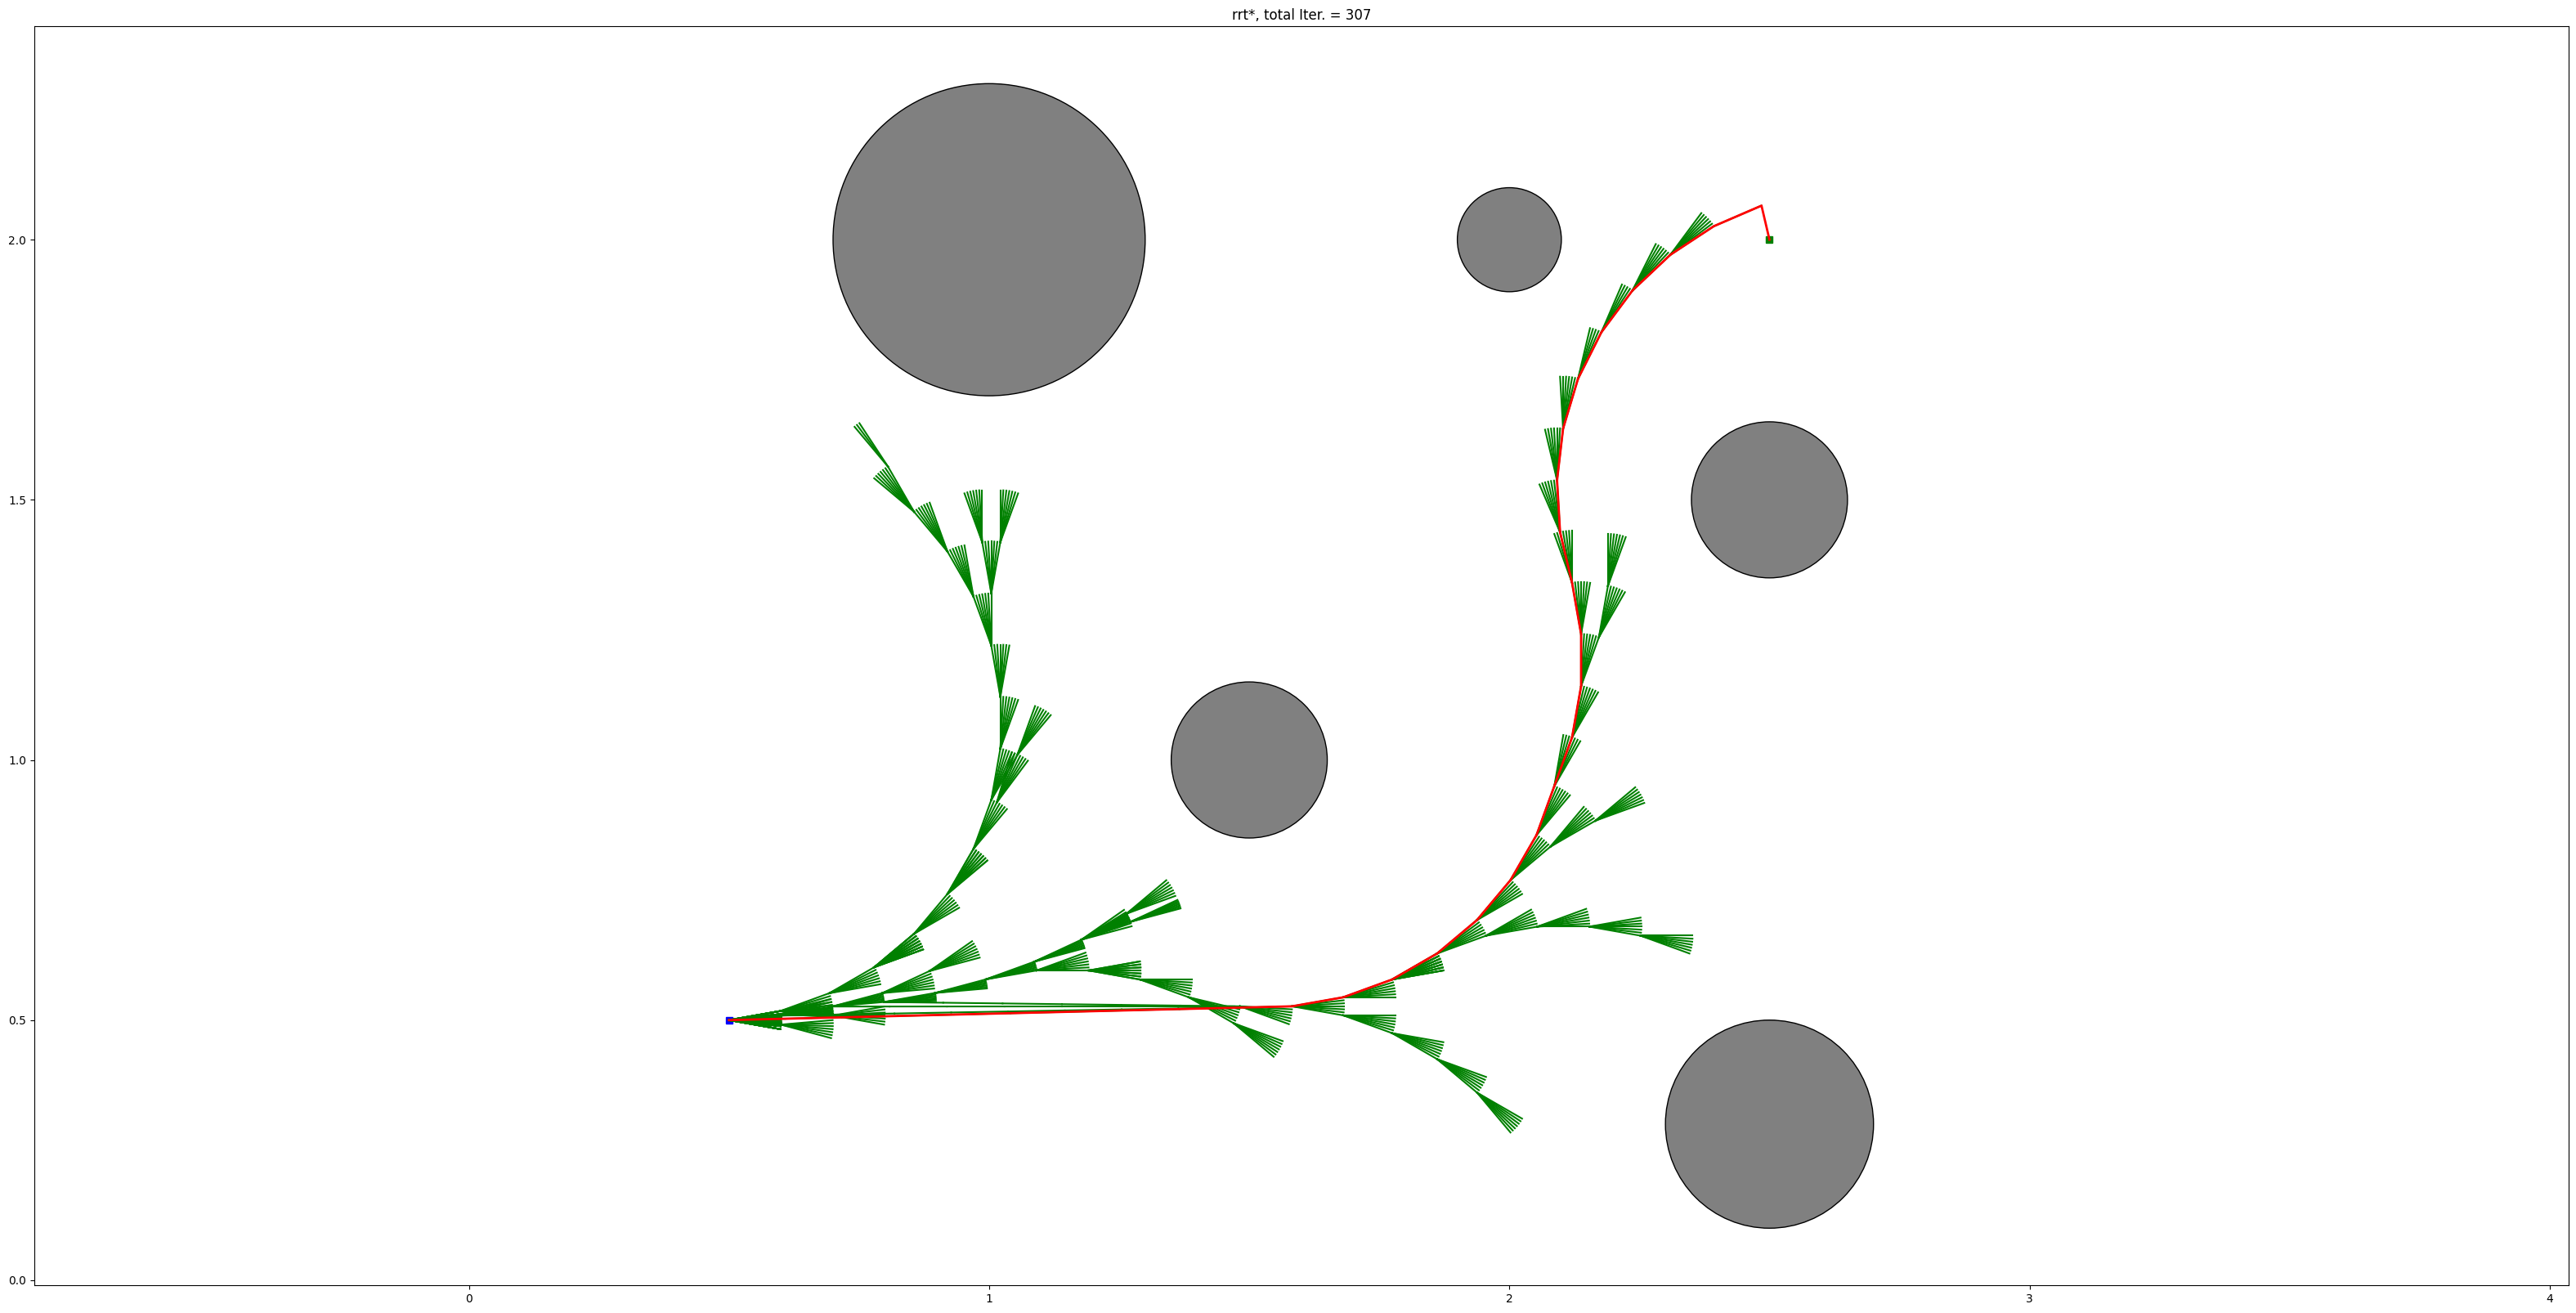

(31, 2)


In [4]:
class DigitState(RrtStar):
      
  # Constructor Method
  def __init__(self, x_start, x_goal, step_len=0.3, goal_sample_rate=0.10, search_radius=0.6, iter_max=10000, max_turn_angle=np.deg2rad(14)):
    super().__init__(x_start, x_goal, step_len, goal_sample_rate, search_radius, iter_max, max_turn_angle)
    
    
    self.goal = x_goal
    
    #constant from Jesse Jiang's Abstraction based planning
    stateLength = 0.15
    footLength = 0.14
    angleSize = 15
    angleLength = 360/angleSize
    footSpace = 0.10012
    
    #initialize trajectory (could take a long time depending on the obstacle density)
    self.plan()
    
    self.path_ordered = np.array(self.path)
    self.path_ordered = self.path_ordered[:len(self.path_ordered) - 1] #Remove the goal
    # self.path_ordered = np.vstack([[[0.3,0.5],[0.4,0.5]], self.path_ordered])
    
    #Create random elevation change at each waypoint
    self.elevation_random = []
    for _ in range(len(self.path)):
        self.elevation_random.append(np.random.uniform(0.0, 0.1, 1))
    self.elevation_random = np.array(self.elevation_random)
    
    #Initialize Apex State
    self.apex_x    =   self.path_ordered[0][0]        
    self.apex_y    =   self.path_ordered[0][1] + 0.02
    self.apex_z    =   1.01  
    self.wp_c_x    =   self.path_ordered[0][0] 
    self.wp_c_y    =   self.path_ordered[0][1]  
    self.wp_n_x    =   self.path_ordered[1][0]   
    self.wp_n_y    =   self.path_ordered[1][1]   
    self.vapex     =   0.15
    self.heading_c = 0
    # _, self.heading_c, _ =   self.compute_action((self.wp_n_x, self.wp_n_y), (self.wp_c_x, self.wp_c_y))  
    self.foot_x    =   self.apex_x
    self.foot_y    =   self.apex_y + 0.03012
    self.foot_z    =   0.0      
    self.step_l , self.dheading, self.dz  = self.compute_action((self.wp_n_x, self.wp_n_y), (self.wp_c_x, self.wp_c_y))  
    self.stance    =   1
    self.frame     =   (self.wp_c_x, self.wp_c_y, self.heading_c)
    
    self.history = {"apex_state":[np.array([self.apex_x, self.apex_y])],
                    "waypoint_track":[np.array([self.wp_c_x,self.wp_c_y])],
                    "foot_position":[np.array([self.foot_x,self.foot_y])],
                    "sagittal":[],
                    "lateral":[],
                    "frame":[]}
    
  
  def compute_action(self, waypoint, current):

    dz = np.random.uniform(-0.05, 0.05, 1)
      
    step_length = np.linalg.norm(np.array([current]) - np.array([waypoint]))
    
    dheading = np.arctan2(waypoint[1] - current[1], waypoint[0]- current[0]) - self.heading_c
    
    return step_length, dheading, dz

x_start = (0.5,0.5)
x_goal = (2.5,2)
# obstacles = np.array([[2.5,1]])#np.array([[3,3], [3,4], [4,3], [5,5], [1.5, 3.5], [2,3], [6,7], [7,7], [7.5,8], [7,4], [7.5,7]]) # 
# grid_bound = (-10, 10, -10, 10) #(xmin xmax ymin ymax)

digit = DigitState(x_start, x_goal, step_len=0.1, goal_sample_rate=0.6, search_radius=0.6, iter_max=10000, max_turn_angle=np.deg2rad(10))

print("Initial State: ")
print("apex_x", digit.apex_x) 
print("apex_y",digit.apex_y)
print("apex_z",digit.apex_z)
print("foot_x",digit.foot_x)
print("foot_y",digit.foot_y)
print("foot_z",digit.foot_z)
print("vapex",digit.vapex)
print("wpx",digit.wp_c_x)
print("wpy",digit.wp_c_y)
print("heading", np.rad2deg(digit.heading_c))
print("-----------------------")
print("High Level action:")
print("step_l",digit.step_l)
print("dheading",np.rad2deg(digit.dheading))
print("step_height", digit.dz)

digit.plot_map()
# digit.path = [(0.0, 0.0), (0.3, 0.0), (0.6, 0.0), (0.75, 0.06), (1.1, 0.06), (1.4, 0.06), (1.7, 0.06), (1.8, 0.0), (2.1, 0.0), (2.4, 0.0)]
print(digit.path_ordered.shape)

In [3]:
digit.path

[[0.5, 0.5],
 [0.5984807753012208, 0.5173648177666931],
 [0.6924500373798116, 0.5515668320992599],
 [0.7790525777582554, 0.60156683209926],
 [0.8556570220701532, 0.6658455930679139],
 [0.9199357830388071, 0.7424500373798117],
 [0.969935783038807, 0.8290525777582556],
 [1.0041377973713739, 0.9230218398368464],
 [1.054137797371374, 1.0096243802152902],
 [1.1184165583400278, 1.086228824527188],
 [1.1950210026519257, 1.150507585495842],
 [1.2833236110799444, 1.2101767069147344],
 [1.3716262195079634, 1.269845828333627],
 [1.459928827935982, 1.3295149497525194],
 [1.5482314363640008, 1.3891840711714118],
 [1.6365340447920196, 1.4488531925903043],
 [1.7248366532200383, 1.5085223140091968],
 [1.8131392616480573, 1.5681914354280893],
 [1.901441870076076, 1.6278605568469817],
 [1.9897444785040947, 1.6875296782658742],
 [2.0780470869321137, 1.7471987996847667],
 [2.1663496953601324, 1.8068679211036591],
 [2.254652303788151, 1.8665370425225516],
 [2.34295491221617, 1.926206163941444],
 [2.4265036

In [5]:
import psp_Aziz as psp
import numpy as np
import matplotlib.pyplot as plt

eps = 0.05
step_max = len(digit.path_ordered) - 2
step = 0

while np.linalg.norm( np.array([digit.apex_x, digit.apex_y]) - digit.goal) > eps and step < step_max:
    step = step + 1
    print("Step #" + str(step) + " out of " + str(step_max))
    
    #Track reference frame
    digit.frame = (digit.wp_c_x, digit.wp_c_y, digit.heading_c)
    digit.history["frame"].append(digit.frame)

    digit.apex_x, digit.apex_y, apex_z, dl_switch, ds_switch, step_length, step_width, step_time, dheading, heading_n, \
        t1, t2, opt_vn, digit.foot_x, digit.foot_y, wp_x_n, wp_y_n, wp_z_n, digit.foot_z, dz, s_switch_g, l_switch_g, sag, lat = \
            psp.apex_Vel_search(digit.apex_x, digit.apex_y, digit.apex_z, digit.wp_c_x, digit.wp_c_y, digit.vapex, digit.foot_x, digit.foot_y, \
                digit.foot_z, np.rad2deg(digit.heading_c), digit.step_l, np.rad2deg(digit.dheading), digit.dz, digit.stance, stop = False, start_flag = True)

    #Update apex_vel
    digit.vapex = opt_vn
    
    #Update heading 
    prev_apex = digit.history["apex_state"][-1]
    digit.heading_c = digit.heading_c + digit.dheading #np.arctan2(digit.apex_y - prev_apex[1], digit.apex_x - prev_apex[0])

    #Update Stance
    digit.stance = 0 if digit.stance else 1
    
    #Update the current waypoint
    digit.wp_c_x = digit.wp_n_x
    digit.wp_c_y = digit.wp_n_y 
    
    #Append new information
    digit.history["apex_state"].append(np.array([digit.apex_x, digit.apex_y]))
    digit.history["waypoint_track"].append(np.array([digit.wp_c_x, digit.wp_c_y]))
    digit.history["foot_position"].append(np.array([digit.foot_x, digit.foot_y]))
    digit.history["sagittal"].append(sag)
    digit.history["lateral"].append(lat)
    
    print("current apex state: ", (digit.apex_x, digit.apex_y))
    
    # #Replanning every 4 steps
    # a = np.where((digit.path_ordered == [digit.wp_c_x, digit.wp_c_y]).all(1))[0][0] #Check that it is not the last step
    
    # if (np.linalg.norm([digit.wp_c_y - digit.apex_y, digit.wp_c_x - digit.apex_x]) > 2 or\
    #     digit.utils.is_inside_obs(Node((digit.apex_x, digit.apex_y)), delta=0.005) or\
    #         digit.utils.is_inside_obs(Node((digit.foot_x, digit.foot_y)), delta=0.005) or\
    #             (step % 4 == 0)) and a < step_max: 
        
    #     print("Replanning...")
        
    #     #Check deviation between current apex state and the optimal path
    #     digit.wp_n_x    =   digit.path_ordered[a + 1][0]
    #     digit.wp_n_y    =   digit.path_ordered[a + 1][1]
    #     _ , digit.dheading, _ = digit.compute_action((digit.wp_n_x, digit.wp_n_y), (digit.apex_x, digit.apex_y))
            
    #     n_turns = float(digit.dheading / digit.max_turn_ang) 
    #     digit.step_len = max(float(digit.step_len_max / n_turns), digit.step_len_min)

    #     digit.replan((digit.apex_x, digit.apex_y), heading_c=digit.heading_c, obstacle_margin=0.01)

    #     #new path
    #     digit.path_ordered = np.array(digit.path)
    #     step_max = len(digit.path_ordered) - 1
    #     step = 0
        
    #     #Update the current waypoint
    #     digit.wp_c_x = digit.path_ordered[0][0] 
    #     digit.wp_c_y = digit.path_ordered[0][1] 
        
            
    #Get next waypoint and next action if its not the last step
    a = np.where((digit.path_ordered == [digit.wp_c_x, digit.wp_c_y]).all(1))[0][0]
    
    if a < step_max:
        digit.wp_n_x    =   digit.path_ordered[a + 1][0]
        digit.wp_n_y    =   digit.path_ordered[a + 1][1]
        digit.step_l , digit.dheading, digit.dz  = digit.compute_action((digit.wp_n_x, digit.wp_n_y), (digit.wp_c_x, digit.wp_c_y))
    
    # digit.dheading = np.sign(digit.dheading) * min(abs(digit.dheading), digit.max_turn_ang)
    
    print("PSP waypoint", (wp_x_n, wp_y_n, wp_z_n))
    print("current waypoint", (digit.wp_c_x, digit.wp_c_y))
    print("next waypoint", (digit.wp_n_x, digit.wp_n_y))
    print("vapex", digit.vapex)
    print("step_l", digit.step_l)
    print("dz", digit.dz)
    print("next dtheta", np.rad2deg(digit.dheading))
    print("PSP dtheta", dheading)
    print("current head", np.rad2deg(digit.heading_c))
    print("PSP current head", heading_n)
    print("PSP t1", t1)
    print("PSP t2", t2)
    print("stance", digit.stance)
    print("-----------------------------------")
    
    
    

Step #1 out of 29
current apex state:  (0.6085715305867769, 0.4882977706730084)
PSP waypoint (0.6082204660831951, 0.5026475856493908, array([1.05507794]))
current waypoint (0.6082204660831951, 0.5026475856493908)
next waypoint (0.7164409321663902, 0.5052951712987817)
vapex 0.2
step_l 0.10825284748695908
dz [0.0372887]
next dtheta 1.3914926731402886e-15
PSP dtheta 1.401446838320774
current head 1.401446838320774
PSP current head 1.401446838320774
PSP t1 0.34900000000000003
PSP t2 0.211
stance 0
-----------------------------------
Step #2 out of 29
current apex state:  (0.7159039164194139, 0.5272457716297497)
PSP waypoint (0.7164409321663902, 0.5052951712987817, array([1.09236664]))
current waypoint (0.7164409321663902, 0.5052951712987817)
next waypoint (0.8246613982495853, 0.5079427569481724)
vapex 0.2
step_l 0.1082528474869592
dz [-0.00588502]
next dtheta -6.023175428021535e-14
PSP dtheta 1.3914926731402886e-15
current head 1.4014468383207754
PSP current head 1.4014468383207754
PSP t1 

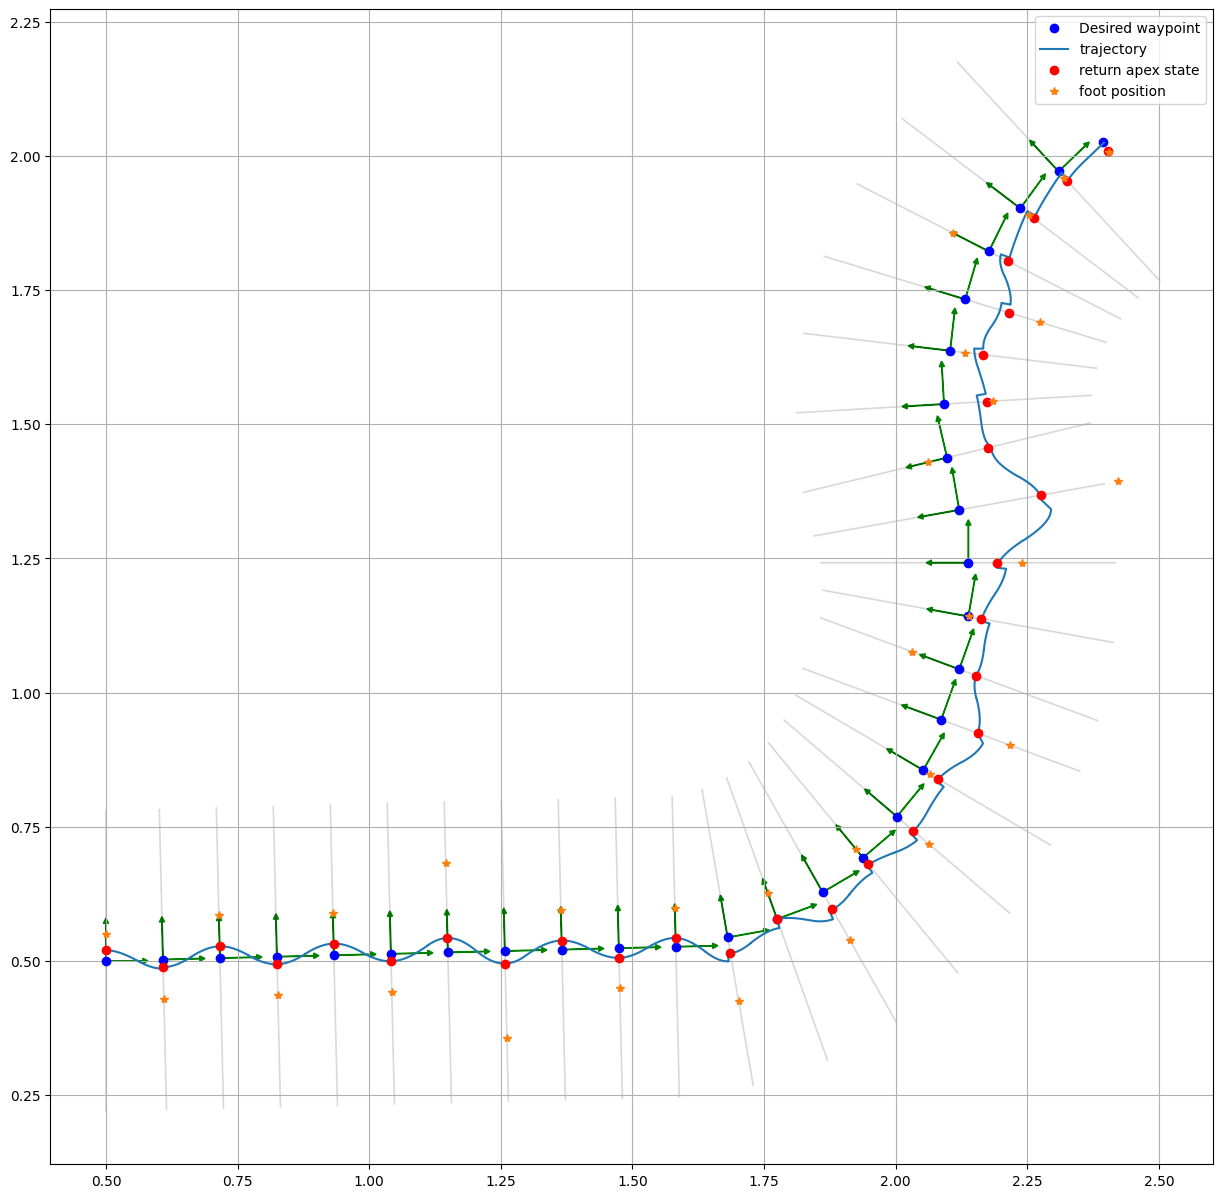

In [6]:
all_sag = np.array([])
all_lat = np.array([])
body_x_axis = np.array([])
body_y_axis = np.array([])

xhat = np.array([0.07, 0])
yhat = np.array([0, 0.07])

for i in range(len(digit.history["sagittal"])):
    
    sag = digit.history["sagittal"][i]
    lat = digit.history["lateral"][i]
    wp_x, wp_y, heading = digit.history["frame"][i]
    
    sag_global = np.array(sag) *np.cos(heading) - np.array(lat) *np.sin(heading) + wp_x
    lat_global = np.array(sag) *np.sin(heading) + np.array(lat) *np.cos(heading) + wp_y
    
    all_sag = np.append(all_sag,sag_global)
    all_lat = np.append(all_lat,lat_global)
    
    # Rotation matrix
    rotation = np.array([
    [np.cos(heading), -np.sin(heading)], 
    [np.sin(heading),  np.cos(heading)]])
    
    if i == 0:
        body_x_axis = np.append(body_x_axis, rotation.dot(xhat))
        body_y_axis = np.append(body_y_axis, rotation.dot(yhat))
    else:
        body_x_axis = np.vstack([body_x_axis, rotation.dot(xhat)])
        body_y_axis = np.vstack([body_y_axis, rotation.dot(yhat)])
        
all_wp_x = np.array(digit.history["waypoint_track"])[:,0]
all_wp_y = np.array(digit.history["waypoint_track"])[:,1]


plt.figure(figsize=(15,15))  
plt.plot(all_wp_x,all_wp_y, "bo", label="Desired waypoint")
plt.plot(all_sag, all_lat, label="trajectory")
plt.plot(np.array(digit.history["apex_state"])[:,0], np.array(digit.history["apex_state"])[:,1], "or", label="return apex state")
plt.plot(np.array(digit.history["foot_position"])[:,0], np.array(digit.history["foot_position"])[:,1], "*", label="foot position")


# Draw body frame axes
for i in range(len(body_x_axis)):
    plt.arrow(all_wp_x[i], all_wp_y[i],  *body_x_axis[i], head_width=0.01, head_length=0.01, fc='g', ec='g')
    plt.arrow(all_wp_x[i], all_wp_y[i],  *body_y_axis[i], head_width=0.01, head_length=0.01, fc='g', ec='g')
    plt.arrow(all_wp_x[i], all_wp_y[i],  *-4*body_y_axis[i], head_width=0.001, head_length=0.001, fc='k', ec='k', alpha=0.1)
    plt.arrow(all_wp_x[i], all_wp_y[i],  *4*body_y_axis[i], head_width=0.001, head_length=0.001, fc='k', ec='k', alpha=0.1)


plt.grid()
plt.legend()

# digit.plot_map()

In [32]:
np.mean(np.array(digit.history["apex_state"])[1:,1] - np.array(digit.history["waypoint_track"])[1:,1])

-0.02278951227236681

In [16]:
digit.history["waypoint_track"]

33

In [7]:
import psp
import numpy as np
import matplotlib.pyplot as plt

eps = 0.05
step_max = len(digit.path_ordered) - 1
step = 0

while np.linalg.norm( np.array([digit.apex_x, digit.apex_y]) - digit.goal) > eps and step < step_max:
    step = step + 1
    print("Step #" + str(step) + " out of " + str(step_max))

    digit.apex_x, digit.apex_y, digit.apex_z, digit.foot_x, digit.foot_y, digit.foot_z, digit.vapex, sag, sag_dot, lat, lat_dot = \
    psp.apex_Vel_search(digit.apex_x, digit.apex_y, digit.apex_z, digit.wp_c_x, digit.wp_c_y, digit.vapex, digit.foot_x, digit.foot_y, \
                digit.foot_z, np.rad2deg(digit.heading_c), digit.step_l, np.rad2deg(digit.dheading), digit.dz, digit.stance, stop = False, start_flag = True)

    #Update heading 
    prev_apex = digit.history["apex_state"][-1]
    digit.heading_c = digit.heading_c + digit.dheading #np.arctan2(digit.apex_y - prev_apex[1], digit.apex_x - prev_apex[0])

    #Update Stance
    digit.stance = 0 if digit.stance else 1
    
    #Update the current waypoint
    digit.wp_c_x = digit.wp_n_x
    digit.wp_c_y = digit.wp_n_y 
    
    #Append new information
    digit.history["apex_state"].append(np.array([digit.apex_x, digit.apex_y]))
    digit.history["waypoint_track"].append(np.array([digit.wp_c_x, digit.wp_c_y]))
    digit.history["foot_position"].append(np.array([digit.foot_x, digit.foot_y]))
    digit.history["sagittal"].append(sag)
    digit.history["lateral"].append(lat)
    
    print("current apex state: ", (digit.apex_x, digit.apex_y))
    
    #Replanning every 4 steps
    a = np.where((digit.path_ordered == [digit.wp_c_x, digit.wp_c_y]).all(1))[0][0] #Check that it is not the last step
    
    if (np.linalg.norm([digit.wp_c_y - digit.apex_y, digit.wp_c_x - digit.apex_x]) > 2 or\
        digit.utils.is_inside_obs(Node((digit.apex_x, digit.apex_y)), delta=0.01) or\
            digit.utils.is_inside_obs(Node((digit.foot_x, digit.foot_y)), delta=0.01) or\
                (step % 4 == 0)) and a < step_max: 
        
        print("Replanning...")
        
        #Check deviation between current apex state and the optimal path
        digit.wp_n_x    =   digit.path_ordered[a + 1][0]
        digit.wp_n_y    =   digit.path_ordered[a + 1][1]
        _ , digit.dheading, _ = digit.compute_action((digit.wp_n_x, digit.wp_n_y), (digit.apex_x, digit.apex_y))
            
        n_turns = float(digit.dheading / digit.max_turn_ang) 
        digit.step_len = max(float(digit.step_len_max / n_turns), digit.step_len_min)

        digit.replan((digit.apex_x, digit.apex_y), heading_c=digit.heading_c, obstacle_margin=0.01)

        #new path
        digit.path_ordered = np.array(digit.path)
        step_max = len(digit.path_ordered) - 1
        step = 0
        
        #Update the current waypoint
        digit.wp_c_x = digit.path_ordered[0][0] 
        digit.wp_c_y = digit.path_ordered[0][1] 
        
            
    #Get next waypoint and next action if its not the last step
    a = np.where((digit.path_ordered == [digit.wp_c_x, digit.wp_c_y]).all(1))[0][0]
    
    if a < step_max:
        digit.wp_n_x    =   digit.path_ordered[a + 1][0]
        digit.wp_n_y    =   digit.path_ordered[a + 1][1]
        digit.step_l , digit.dheading, digit.dz  = digit.compute_action((digit.wp_n_x, digit.wp_n_y), (digit.wp_c_x, digit.wp_c_y))
    
    # digit.dheading = np.sign(digit.dheading) * min(abs(digit.dheading), digit.max_turn_ang)
    
    print("next waypoint", (digit.wp_n_x, digit.wp_n_y))
    print("vapex", digit.vapex)
    print("step_l", digit.step_l)
    print("dz", digit.dz)
    print("dtheta", np.rad2deg(digit.dheading))
    print("current head", np.rad2deg(digit.heading_c))
    print("-----------------------------------")
    
    #Next frame
    digit.frame = (digit.wp_c_x, digit.wp_c_y, digit.heading_c)
    digit.history["frame"].append(digit.frame)


81

In [6]:
len(rrt_star.m_list)

77

In [4]:
path_ordered = rrt_star.get_ordered_path_numpy()

index = 31
some_node = path_ordered[index]
next_node = path_ordered[index + 1]
dy = next_node[1] - some_node[1]
dx = next_node[0] - some_node[0]

heading_c = np.arctan2(dy, dx)
print(some_node)
print(np.rad2deg(heading_c))

[26.06985373 12.53741149]
28.00000000000016


Node 0: 
x:  18
y:  28
parent: None
---------------------------------
---------------------------------
Branching out the new start node! (May be high computation)
Node 0: 
x:  18.2910887178828
y:  27.9274234313201
parent: (18, 28)
---------------------------------
Branching out the new start node! (May be high computation)
Node 0: 
x:  18.55597299574048
y:  27.786581962484334
parent: (18.2910887178828, 27.9274234313201)
---------------------------------
Branching out the new start node! (May be high computation)
Node 0: 
x:  18.820857273598158
y:  27.645740493648567
parent: (18.55597299574048, 27.786581962484334)
---------------------------------
Branching out the new start node! (May be high computation)
Node 0: 
x:  19.085741551455836
y:  27.5048990248128
parent: (18.820857273598158, 27.645740493648567)
---------------------------------
Branching out the new start node! (May be high computation)
Node 0: 
x:  19.350625829313515
y:  27.364057555977034
parent: (19.085741551455836, 27.5

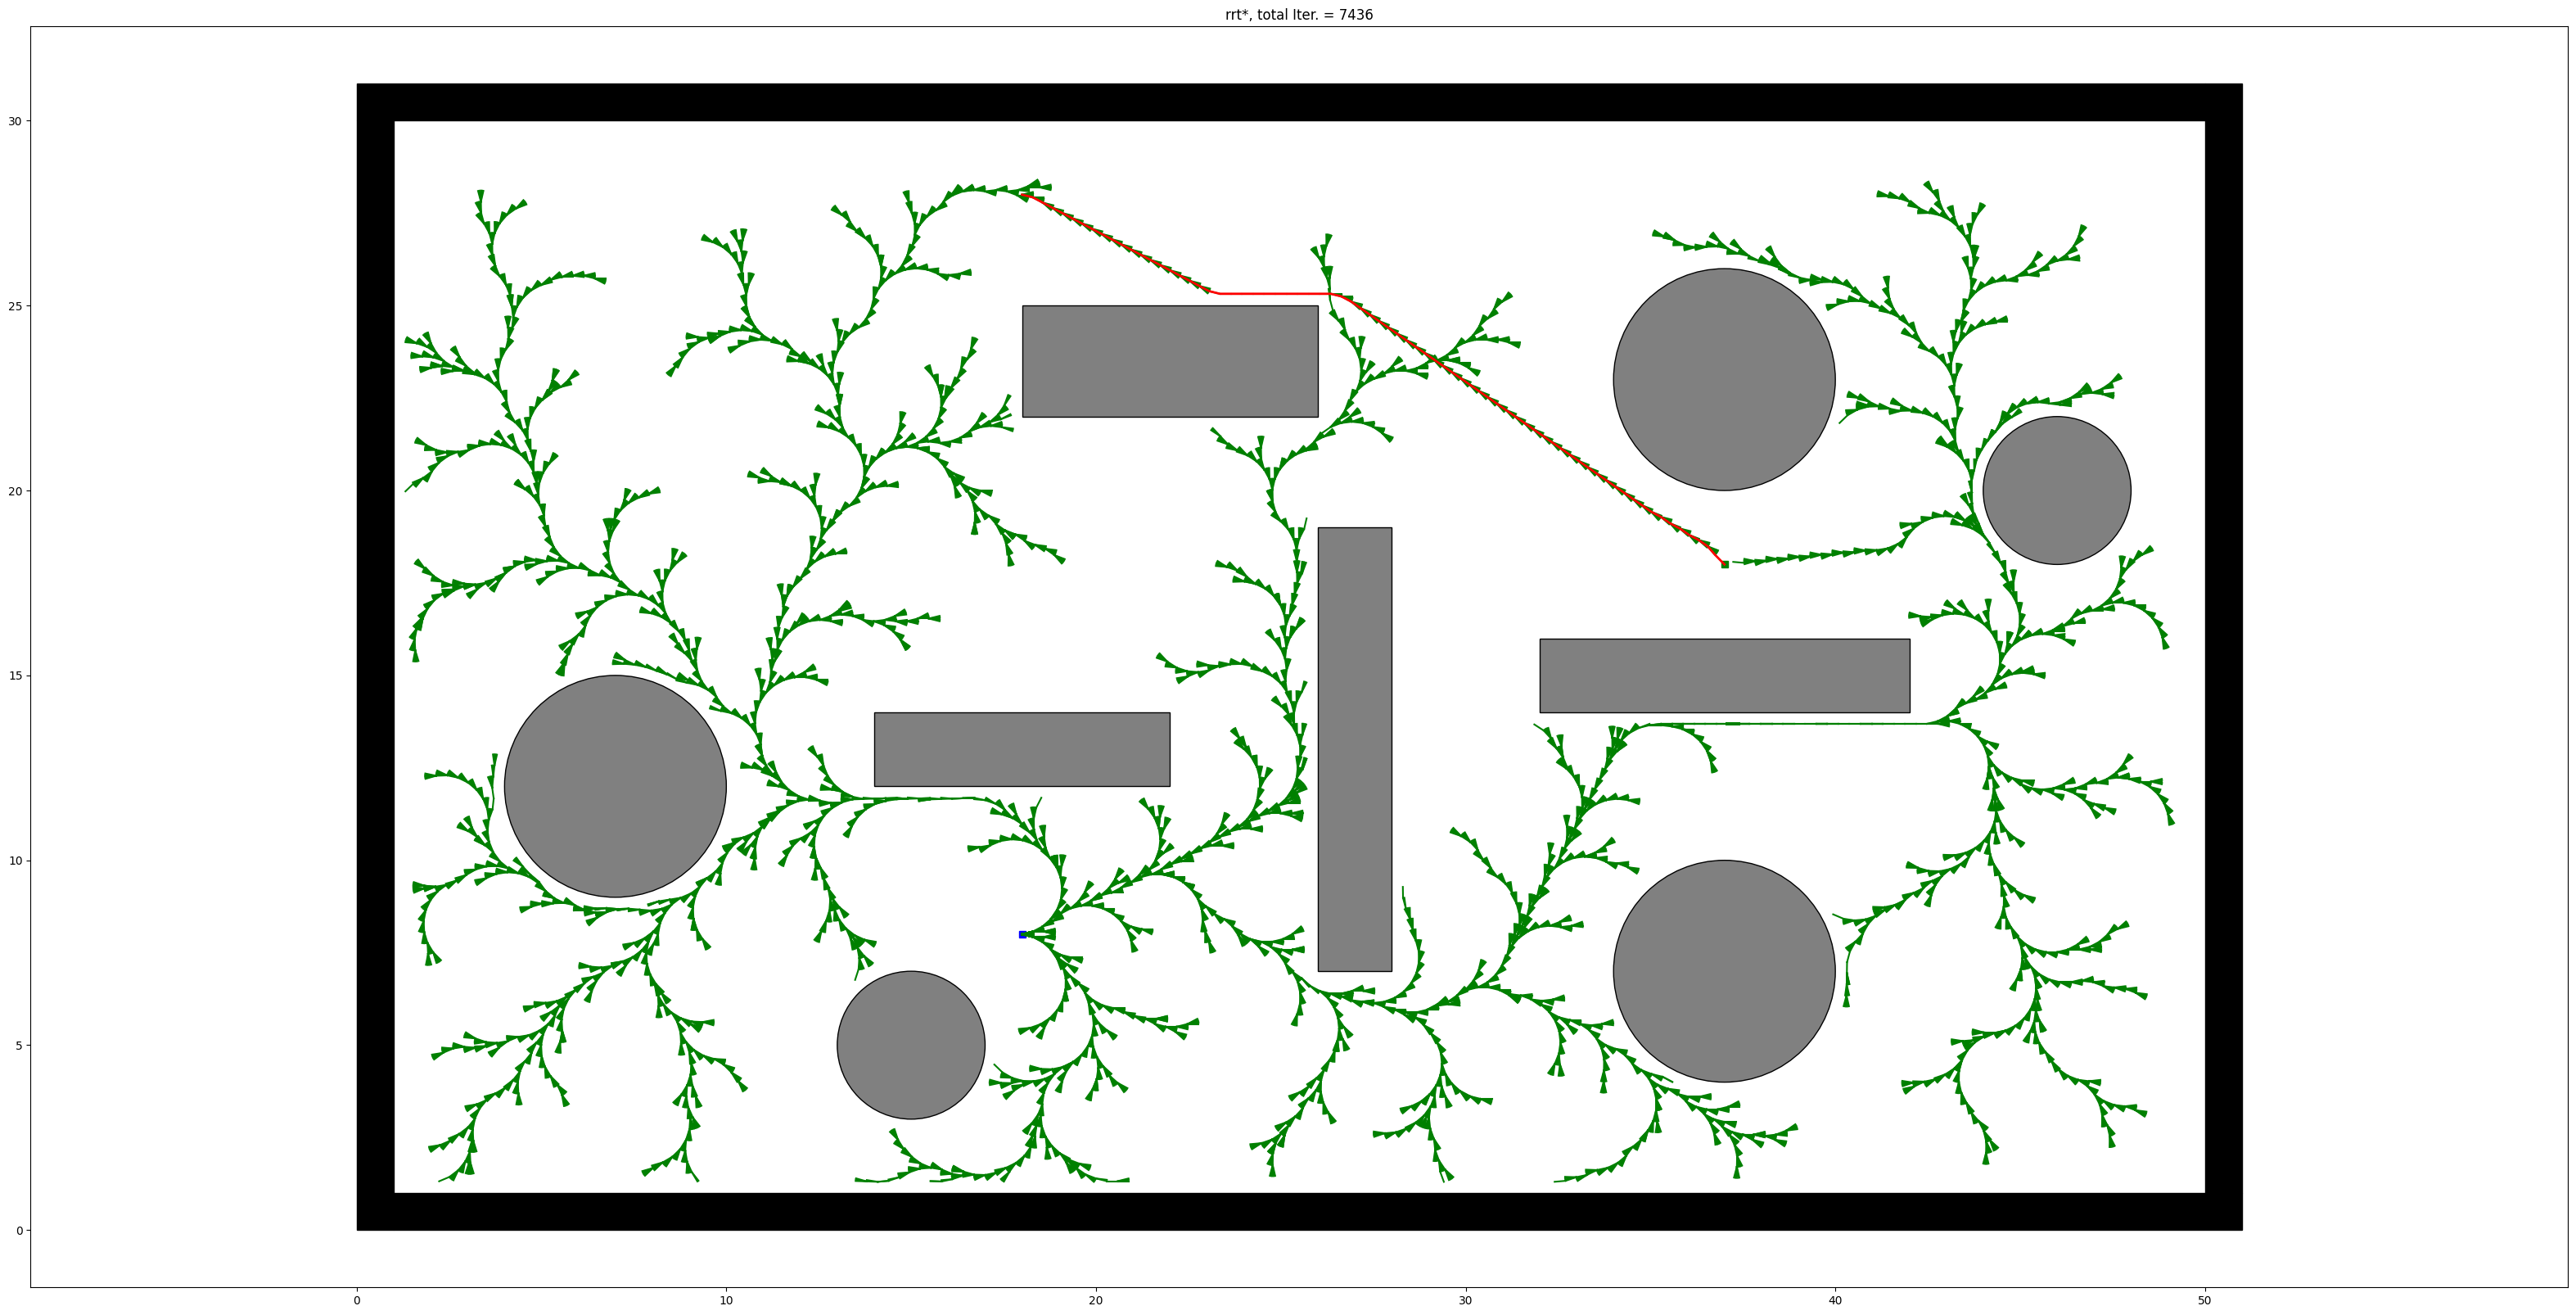

In [4]:
rrt_star.replan((18,28), heading_c=np.deg2rad(0))
rrt_star.plot_map()

In [8]:
new_start = Node((26,11))
heading_c=np.deg2rad(45)

for path_node in rrt_star.path_vertex:
    path_node.print_node_chain(show_parents=False)
    # dist, ang = rrt_star.get_distance_and_angle(new_start, path_node)
    # print(dist)
    # print(np.rad2deg(ang - heading_c))

Node 0: 
x:  18.2910887178828
y:  8.072576568679901
parent: (18, 8)
---------------------------------
Node 0: 
x:  18.55597299574048
y:  8.21341803751567
parent: (18.2910887178828, 8.072576568679901)
---------------------------------
Node 0: 
x:  18.778916443383697
y:  8.414157219423327
parent: (18.55597299574048, 8.21341803751567)
---------------------------------
Node 0: 
x:  19.043800721241375
y:  8.554998688259095
parent: (18.778916443383697, 8.414157219423327)
---------------------------------
Node 0: 
x:  19.308684999099054
y:  8.695840157094864
parent: (19.043800721241375, 8.554998688259095)
---------------------------------
Node 0: 
x:  19.573569276956732
y:  8.836681625930632
parent: (19.308684999099054, 8.695840157094864)
---------------------------------
Node 0: 
x:  19.79651272459995
y:  9.03742080783829
parent: (19.573569276956732, 8.836681625930632)
---------------------------------
Node 0: 
x:  20.06139700245763
y:  9.178262276674058
parent: (19.79651272459995, 9.0374208

In [16]:
type(rrt_star.path_vertex)

list

In [8]:
rrt_star.path

[[37, 18],
 [36.624466497859196, 18.168324292194015],
 [36.456708626817964, 18.417035563960525],
 [36.23376517917474, 18.61777474586818],
 [35.96888090131706, 18.75861621470394],
 [35.677792183434256, 18.831192783383838],
 [35.412907905576574, 18.9720342522196],
 [35.16716229228987, 19.14410718312491],
 [34.90227801443219, 19.28494865196067],
 [34.63739373657451, 19.425790120796428],
 [34.37250945871683, 19.566631589632188],
 [34.107625180859145, 19.707473058467947],
 [33.84274090300146, 19.848314527303707],
 [33.61979745535824, 20.049053709211357],
 [33.354913177500556, 20.189895178047117],
 [33.090028899642874, 20.330736646882876],
 [32.80995477169371, 20.438247031746457],
 [32.51219092620131, 20.47480783476799],
 [32.214427080708916, 20.438247031746435],
 [31.916663235216518, 20.47480783476797],
 [31.61889938972412, 20.511368637789502],
 [31.31889938972412, 20.51136863778949],
 [31.027810671841323, 20.43879206910958],
 [30.762926393983648, 20.297950600273804],
 [30.47183767610085, 2

In [11]:
rrt_star.get_ordered_path_numpy()

#Interpolated steplenght ruin the heading change. FIX THIS!!!!

array([[30.        , 14.        ],
       [30.26188719, 14.15226535],
       [30.52377438, 14.3045307 ],
       [30.78865866, 14.44537217],
       [31.05354294, 14.58621364],
       [31.27648639, 14.78695282],
       [31.44424426, 15.0356641 ],
       [31.5468503 , 15.31757188],
       [31.57820884, 15.61592845],
       [31.60956738, 15.91428502],
       [31.6770527 , 16.20659604],
       [31.74453801, 16.49890706],
       [31.88073516, 16.76620902],
       [32.07755287, 16.99262189],
       [32.32329848, 17.16469482],
       [32.52011619, 17.39110769],
       [32.68787406, 17.63981897],
       [32.91081751, 17.84055815],
       [33.15656313, 18.01263108],
       [33.43663725, 18.12014146],
       [33.68238287, 18.29221439],
       [33.96245699, 18.39972478],
       [34.26022084, 18.43628558],
       [34.54029497, 18.54379597],
       [34.83805881, 18.58035677],
       [35.13582266, 18.61691757],
       [35.4335865 , 18.58035677],
       [35.71366063, 18.47284639],
       [36.01142448,

In [12]:
np.rad2deg(np.arctan2(30.26188719 - 30 , 14.15226535 - 14)) - 40


19.82560424642915

In [7]:
heading_c=  0
np.rad2deg(np.linspace(heading_c - rrt_star.max_turn_ang, heading_c + rrt_star.max_turn_ang, 7))

array([-14.        ,  -9.33333333,  -4.66666667,   0.        ,
         4.66666667,   9.33333333,  14.        ])

In [14]:
rrt_test = RrtStar(x_start, x_goal, step_len=0.5, goal_sample_rate=0.10, search_radius=0.6, iter_max=10000)


for node in rrt_test.vertex:
    node.print_node_chain()

iters = 200
counter = 0

for _ in range(iters):
    counter += 1
    node_rand = rrt_test.generate_random_node(rrt_test.goal_sample_rate)
    node_near = rrt_test.nearest_neighbor(rrt_test.vertex, node_rand)
    node_new = rrt_test.new_state(node_near, node_rand)

    #print new point found
    print("New node found!")
    node_new.print_node_chain()

    #print vertex
    print("Current Vertex!")
    index = 0
    for node in rrt_test.vertex:
        print("vertex[index]: ", index)
        node.print_node_chain(show_parents=False)
        index += 1

    #Check if path from nearet tree node to the new node is safe
    if node_new and not rrt_test.utils.is_collision(node_near, node_new):
        print("New node is valid!")
        neighbor_index = rrt_test.find_near_neighbor(node_new) #find other nearby nodes
        rrt_test.vertex.append(node_new) #append new node to the vertex

        if neighbor_index:
            print("there are other neightbors")
            rrt_test.choose_parent(node_new, neighbor_index)
            rrt_test.rewire(node_new, neighbor_index)
    
    #print vertex
    # print("Printing vertex 2nd times")
    # index = 0
    # for node in rrt_test.vertex:
    #     print("vertex[index]: ", index)
    #     node.print_node_chain()
    #     index += 1
    
    if neighbor_index:
        break
            
    if math.hypot(node_new.x - rrt_test.s_goal.x, node_new.y - rrt_test.s_goal.y) <= 0.5:
        break
    
    print("---------------- END OF ITERATION ------------------")
        

counter

Node 0: 
x:  18
y:  8
parent: None
---------------------------------
---------------------------------
New node found!
Node 0: 
x:  18.442459111190992
y:  8.23287321641631
parent: (18, 8)
---------------------------------
Node 1: 
x:  18
y:  8
parent: None
---------------------------------
---------------------------------
Current Vertex!
vertex[index]:  0
Node 0: 
x:  18
y:  8
parent: None
---------------------------------
---------------------------------
New node is valid!
---------------- END OF ITERATION ------------------
New node found!
Node 0: 
x:  17.53744402409757
y:  8.189847225834225
parent: (18, 8)
---------------------------------
Node 1: 
x:  18
y:  8
parent: None
---------------------------------
---------------------------------
Current Vertex!
vertex[index]:  0
Node 0: 
x:  18
y:  8
parent: None
---------------------------------
---------------------------------
vertex[index]:  1
Node 0: 
x:  18.442459111190992
y:  8.23287321641631
parent: (18, 8)
--------------------

33

In [2]:
class DigitState(RrtStar):
      
  # Constructor Method
  def __init__(self, x_start, x_goal, step_len=0.3, goal_sample_rate=0.10, search_radius=0.6, iter_max=10000, max_turn_angle=np.deg2rad(14)):
    super().__init__(x_start, x_goal, step_len, goal_sample_rate, search_radius, iter_max, max_turn_angle)
    
    
    self.goal = x_goal
    
    #constant from Jesse Jiang's Abstraction based planning
    stateLength = 0.15
    footLength = 0.14
    angleSize = 15
    angleLength = 360/angleSize
    footSpace = 0.10012
    
    #initialize trajectory (could take a long time depending on the obstacle density)
    self.plan(obstacle_margin=1)
    
    self.path_ordered = np.array(self.path)
    
    #Create random elevation change at each waypoint
    self.elevation_random = []
    for _ in range(len(self.path)):
        self.elevation_random.append(np.random.uniform(0.0, 0.1, 1))
    self.elevation_random = np.array(self.elevation_random)
    
    #Initialize Apex State
    self.apex_x    =   x_start[0]        
    self.apex_y    =   x_start[1] - 0.05 - 0.1
    self.apex_z    =   0.0  
    self.wp_c_x    =   x_start[0] 
    self.wp_c_y    =   x_start[1]   
    self.wp_n_x    =   self.path_ordered[1][0]   
    self.wp_n_y    =   self.path_ordered[1][1]   
    self.vapex     =   0.15#0.25
    self.heading_c =   0
    self.foot_x    =   self.apex_x
    self.foot_y    =   self.apex_y -  0.13012 - 0.1
    self.foot_z    =   0.0      
    self.step_l , self.dheading, self.dz  = self.compute_action((self.wp_n_x, self.wp_n_y))  
    self.stance    =   1
    self.frame     =   (self.wp_c_x, self.wp_c_y, self.heading_c)
    
    self.history = {"apex_state":[np.array([self.apex_x, self.apex_y])],
                    "waypoint_track":[np.array([self.wp_c_x,self.wp_c_y])],
                    "foot_position":[np.array([self.foot_x,self.foot_y])],
                    "sagittal":[],
                    "lateral":[],
                    "frame":[self.frame]}
    
  
  def compute_action(self, waypoint, current_loc=None):
    if current_loc is None:
      current_loc = np.array([self.wp_c_x, self.wp_c_y])
      
    
    #Easy implementation for proof of concept
    next_index = np.where(self.path_ordered  == waypoint)[0][1]
    curr_index = np.where(self.path_ordered  == np.array([self.wp_c_x, self.wp_c_y]))[0][1]
    
    dz = self.elevation_random[next_index] - self.elevation_random[curr_index]
      
    step_length = np.linalg.norm(current_loc - np.array(waypoint))
    dheading = np.arctan2(waypoint[1] - current_loc[1], waypoint[0]- current_loc[0]) - self.heading_c
    
    return step_length, dheading, dz


x_start = (18, 8)  # Starting node
x_goal = (37, 18)  # Goal node

obstacles = np.array([[2.5,1]])#np.array([[3,3], [3,4], [4,3], [5,5], [1.5, 3.5], [2,3], [6,7], [7,7], [7.5,8], [7,4], [7.5,7]]) # 
grid_bound = (-10, 10, -10, 10) #(xmin xmax ymin ymax)

digit = DigitState(x_start, x_goal, step_len=0.3, goal_sample_rate=0.6, search_radius=0.6, iter_max=10000, max_turn_angle=np.deg2rad(10))

print("Initial State: ")
print("apex_x", digit.apex_x) 
print("apex_y",digit.apex_y)
print("apex_z",digit.apex_z)
print("foot_x",digit.foot_x)
print("foot_y",digit.foot_y)
print("foot_z",digit.foot_z)
print("vapex",digit.vapex)
print("wpx",digit.wp_c_x)
print("wpy",digit.wp_c_y)
print("heading", np.rad2deg(digit.heading_c))
print("-----------------------")
print("High Level action:")
print("step_l",digit.step_l)
print("dheading",np.rad2deg(digit.dheading))

digit.plot_map()
# digit.path = [(0.0, 0.0), (0.3, 0.0), (0.6, 0.0), (0.75, 0.06), (1.1, 0.06), (1.4, 0.06), (1.7, 0.06), (1.8, 0.0), (2.1, 0.0), (2.4, 0.0)]
print(digit.path_ordered.shape)


0
500
1000
For (18.0, 8.0) and (18.3, 8.0), m = 0.06 and c1 = 6.95, c2 = 6.95.
For (18.3, 8.0) and (18.6, 8.1), m = 0.24 and c1 = 3.68, c2 = 3.68.
For (18.6, 8.1) and (18.9, 8.2), m = 0.43 and c1 = 0.07, c2 = 0.07.
For (18.9, 8.2) and (19.2, 8.3), m = 0.24 and c1 = 3.73, c2 = 3.73.
For (19.2, 8.3) and (19.4, 8.4), m = 0.43 and c1 = 0.01, c2 = 0.01.
For (19.4, 8.4) and (19.7, 8.5), m = 0.24 and c1 = 3.79, c2 = 3.79.
For (19.7, 8.5) and (20.0, 8.6), m = 0.43 and c1 = -0.05, c2 = -0.05.
For (20.0, 8.6) and (20.3, 8.7), m = 0.58 and c1 = -2.97, c2 = -2.97.
For (20.3, 8.7) and (20.5, 8.9), m = 0.58 and c1 = -2.97, c2 = -2.97.
For (20.5, 8.9) and (20.8, 9.0), m = 0.66 and c1 = -4.62, c2 = -4.62.
For (20.8, 9.0) and (21.0, 9.2), m = 0.58 and c1 = -2.95, c2 = -2.95.
For (21.0, 9.2) and (21.3, 9.3), m = 0.58 and c1 = -2.95, c2 = -2.95.
For (21.3, 9.3) and (21.6, 9.5), m = 0.58 and c1 = -2.95, c2 = -2.95.
For (21.6, 9.5) and (21.8, 9.6), m = 0.58 and c1 = -2.95, c2 = -2.95.
For (21.8, 9.6) and (

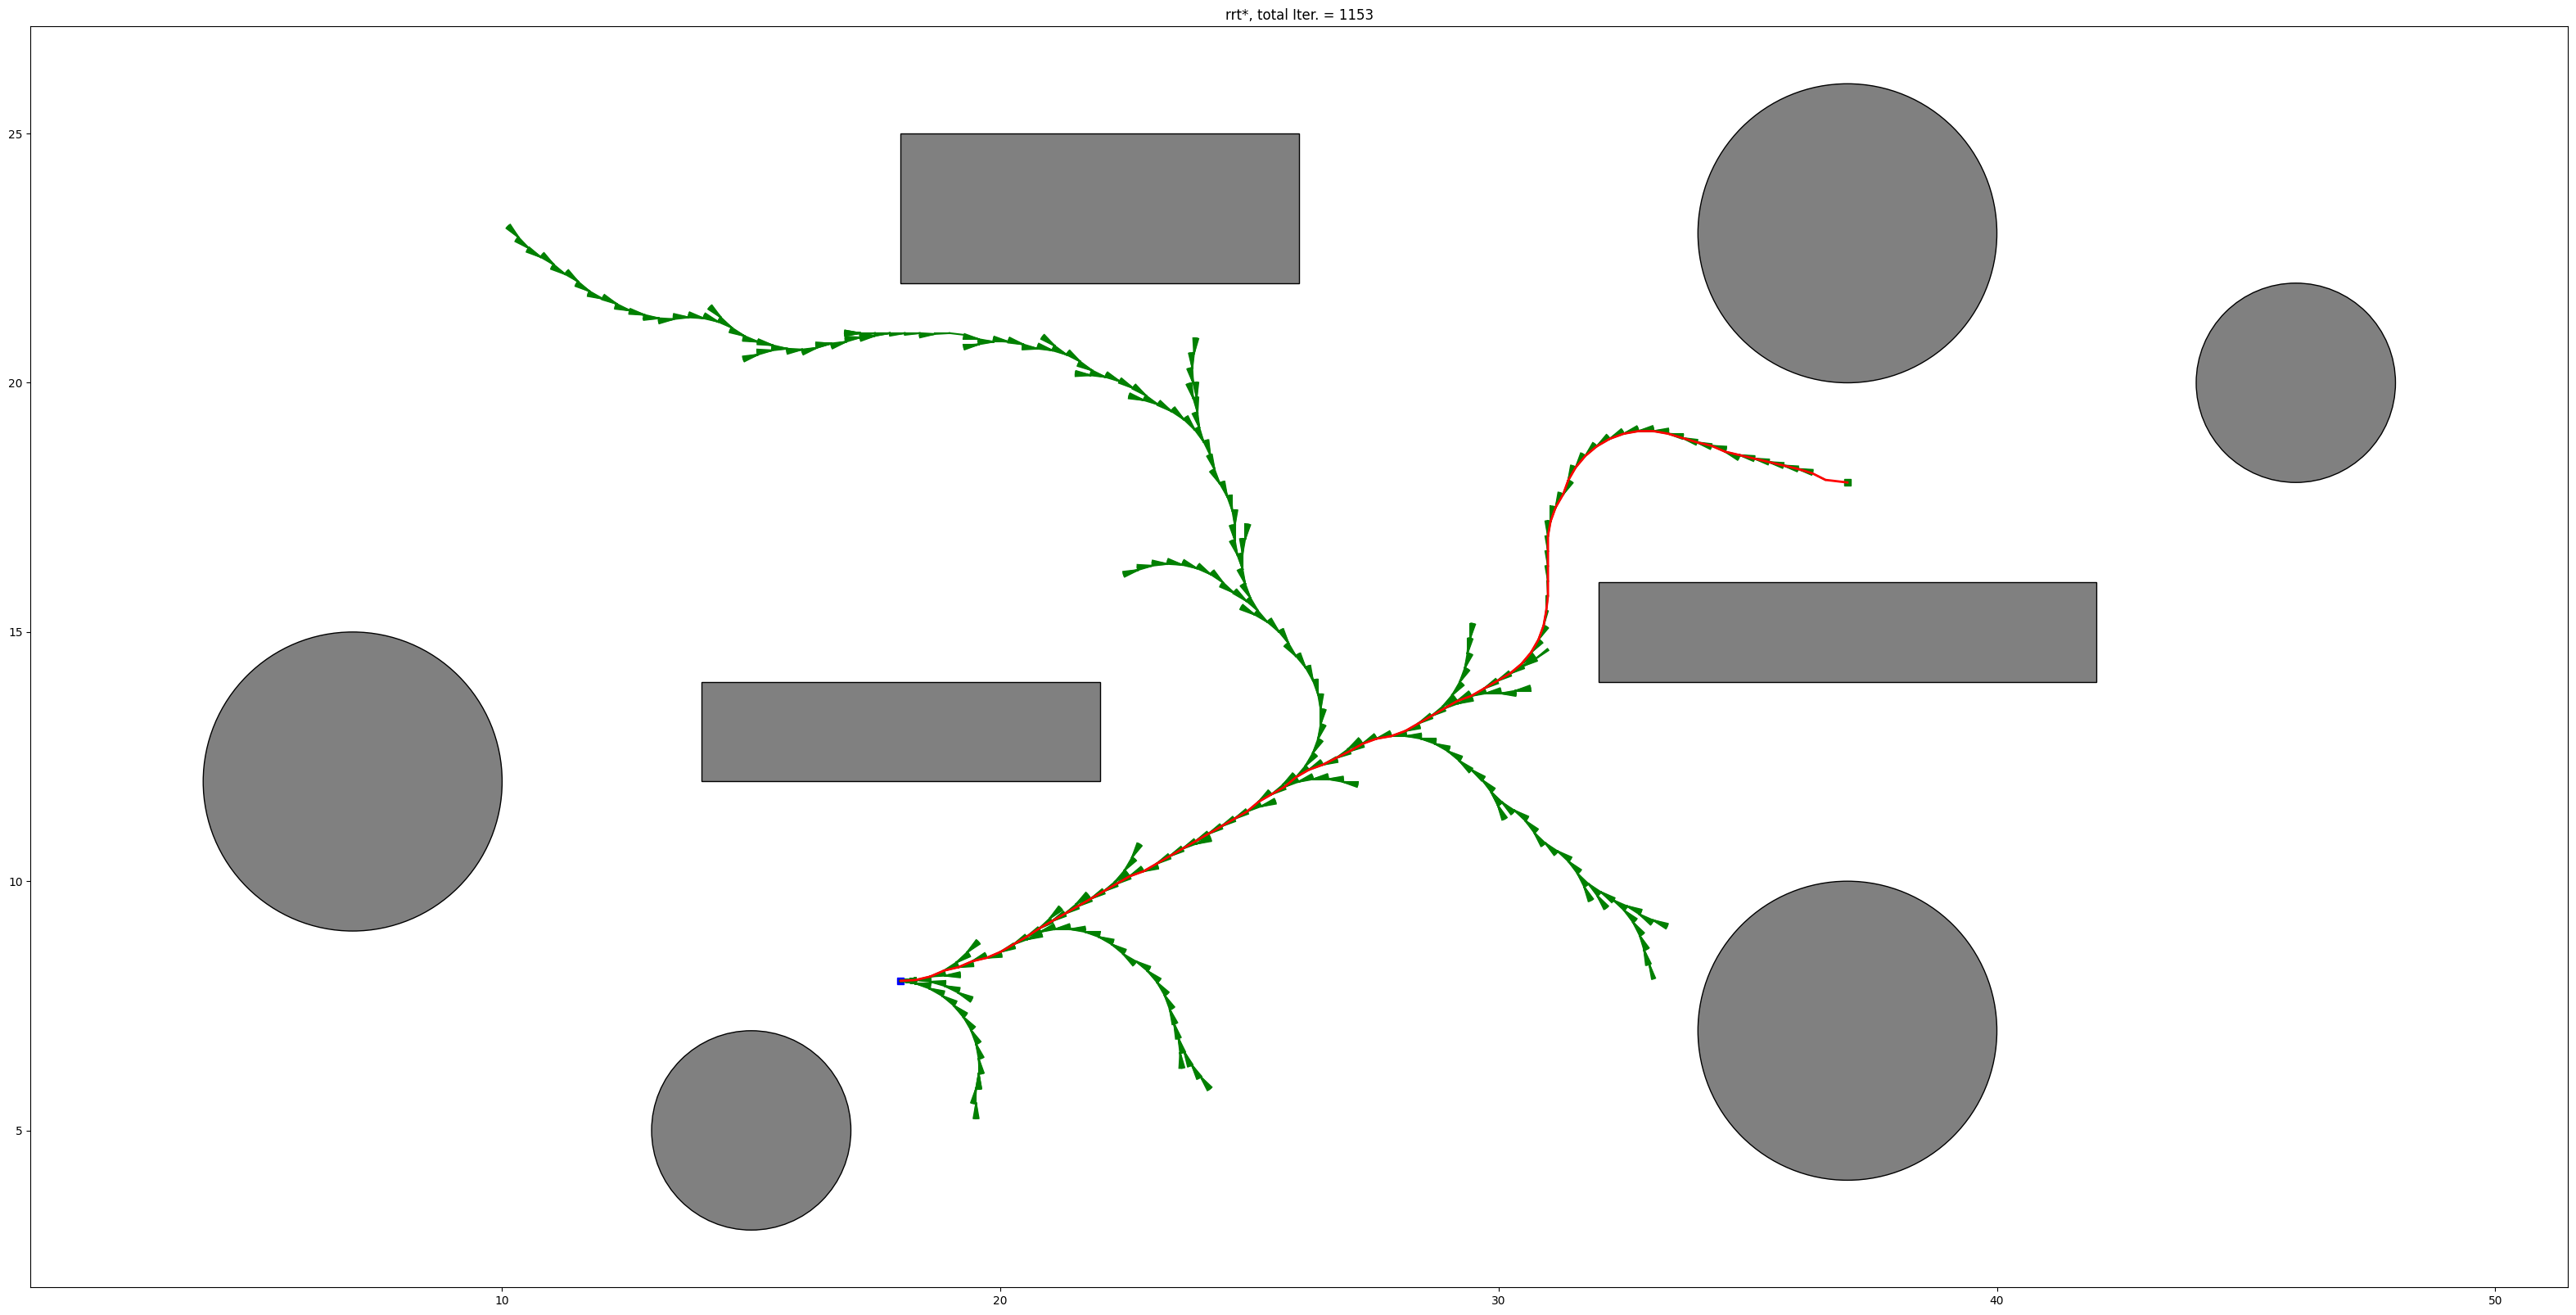

(81, 2)


In [8]:
import psp
import numpy as np
import matplotlib.pyplot as plt

eps = 0.05
step_max = len(digit.path_ordered) - 1
step = 0

while np.linalg.norm( np.array([digit.apex_x, digit.apex_y]) - digit.goal) > eps and step < step_max:
    step = step + 1
    print("Step #" + str(step) + " out of " + str(step_max))

    digit.apex_x, digit.apex_y, digit.apex_z, digit.foot_x, digit.foot_y, digit.foot_z, digit.vapex, sag, sag_dot, lat, lat_dot = \
    psp.apex_Vel_search(digit.apex_x, digit.apex_y, digit.apex_z, digit.wp_c_x, digit.wp_c_y, digit.vapex, digit.foot_x, digit.foot_y, \
                digit.foot_z, np.rad2deg(digit.heading_c), digit.step_l, np.rad2deg(digit.dheading), digit.dz, digit.stance, stop = False, start_flag = True)

    #Update heading 
    prev_apex = digit.history["apex_state"][-1]
    digit.heading_c = digit.heading_c + digit.dheading #np.arctan2(digit.apex_y - prev_apex[1], digit.apex_x - prev_apex[0])

    #Update Stance
    digit.stance = 0 if digit.stance else 1
    
    #Update the current waypoint
    digit.wp_c_x = digit.wp_n_x
    digit.wp_c_y = digit.wp_n_y 
    
    #Append new information
    digit.history["apex_state"].append(np.array([digit.apex_x, digit.apex_y]))
    digit.history["waypoint_track"].append(np.array([digit.wp_c_x, digit.wp_c_y]))
    digit.history["foot_position"].append(np.array([digit.foot_x, digit.foot_y]))
    digit.history["sagittal"].append(sag)
    digit.history["lateral"].append(lat)
    
    #Replanning every 4 steps
    a = np.where((digit.path_ordered == [digit.wp_c_x, digit.wp_c_y]).all(1))[0][0] #Check that it is not the last step
    if (np.linalg.norm([digit.wp_c_y - digit.apex_y, digit.wp_c_x - digit.apex_x]) > 2 or (step % 4 == 0)) and a < step_max:
        
        print("Replanning...")
        print("current apex state: ", (digit.apex_x, digit.apex_y))
        
        #Check deviation between current apex state and the optimal path
        digit.wp_n_x    =   digit.path_ordered[a + 1][0]
        digit.wp_n_y    =   digit.path_ordered[a + 1][1]
        _ , digit.dheading, _ = digit.compute_action((digit.wp_n_x, digit.wp_n_y), (digit.apex_x, digit.apex_y))
            
        n_turns = float(digit.dheading / digit.max_turn_ang) 
        digit.step_len = max(float(digit.step_len_max / n_turns), digit.step_len_min)

        digit.replan((digit.apex_x, digit.apex_y), heading_c=digit.heading_c, obstacle_margin=0.01)

        #new path
        digit.path_ordered = np.array(digit.path)
        step_max = len(digit.path_ordered) - 1
        step = 0
        
        #Update the current waypoint
        digit.wp_c_x = digit.path_ordered[0][0] 
        digit.wp_c_y = digit.path_ordered[0][1] 
        
            
    #Get next waypoint and next action if its not the last step
    a = np.where((digit.path_ordered == [digit.wp_c_x, digit.wp_c_y]).all(1))[0][0]
    
    if a < step_max:
        digit.wp_n_x    =   digit.path_ordered[a + 1][0]
        digit.wp_n_y    =   digit.path_ordered[a + 1][1]
        digit.step_l , digit.dheading, digit.dz  = digit.compute_action((digit.wp_n_x, digit.wp_n_y), (digit.wp_c_x, digit.wp_c_y))
    
    # digit.dheading = np.sign(digit.dheading) * min(abs(digit.dheading), digit.max_turn_ang)
    
    print("next waypoint", (digit.wp_n_x, digit.wp_n_y))
    print("vapex", digit.vapex)
    print("step_l", digit.step_l)
    print("dz", digit.dz)
    print("dtheta", np.rad2deg(digit.dheading))
    print("current head", np.rad2deg(digit.heading_c))
    print("-----------------------------------")
    
    #Next frame
    digit.frame = (digit.wp_c_x, digit.wp_c_y, digit.heading_c)
    digit.history["frame"].append(digit.frame)
    
    
    # digit.apex_x = digit.wp_c_x
    # digit.apex_y = digit.wp_c_y


Step #1 out of 80
next waypoint (18.59140590865533, 8.086628209895876)
vapex 0.18999999999999995
step_l 0.300000000000001
dz [0.00157809]
dtheta 10.000000000000014
current head 3.333333333333413
-----------------------------------
Step #2 out of 80
next waypoint (18.86687074071941, 8.205452139707623)
vapex 0.1
step_l 0.2999999999999988
dz [0.08349215]
dtheta 9.999999999999913
current head 13.333333333333428
-----------------------------------
Step #3 out of 80
next waypoint (19.158784201893358, 8.274636900930355)
vapex 0.25
step_l 0.300000000000001
dz [-0.00227706]
dtheta -9.999999999999913
current head 23.33333333333334
-----------------------------------
Step #4 out of 80
Replanning...
current apex state:  (19.203921446969314, 8.084187888675192)
Node 0: 
x:  19.203921446969314
y:  8.084187888675192
parent: None
---------------------------------
---------------------------------
Check if the start node overlaps the path
Branching out the start node!
there are admissible node to explor

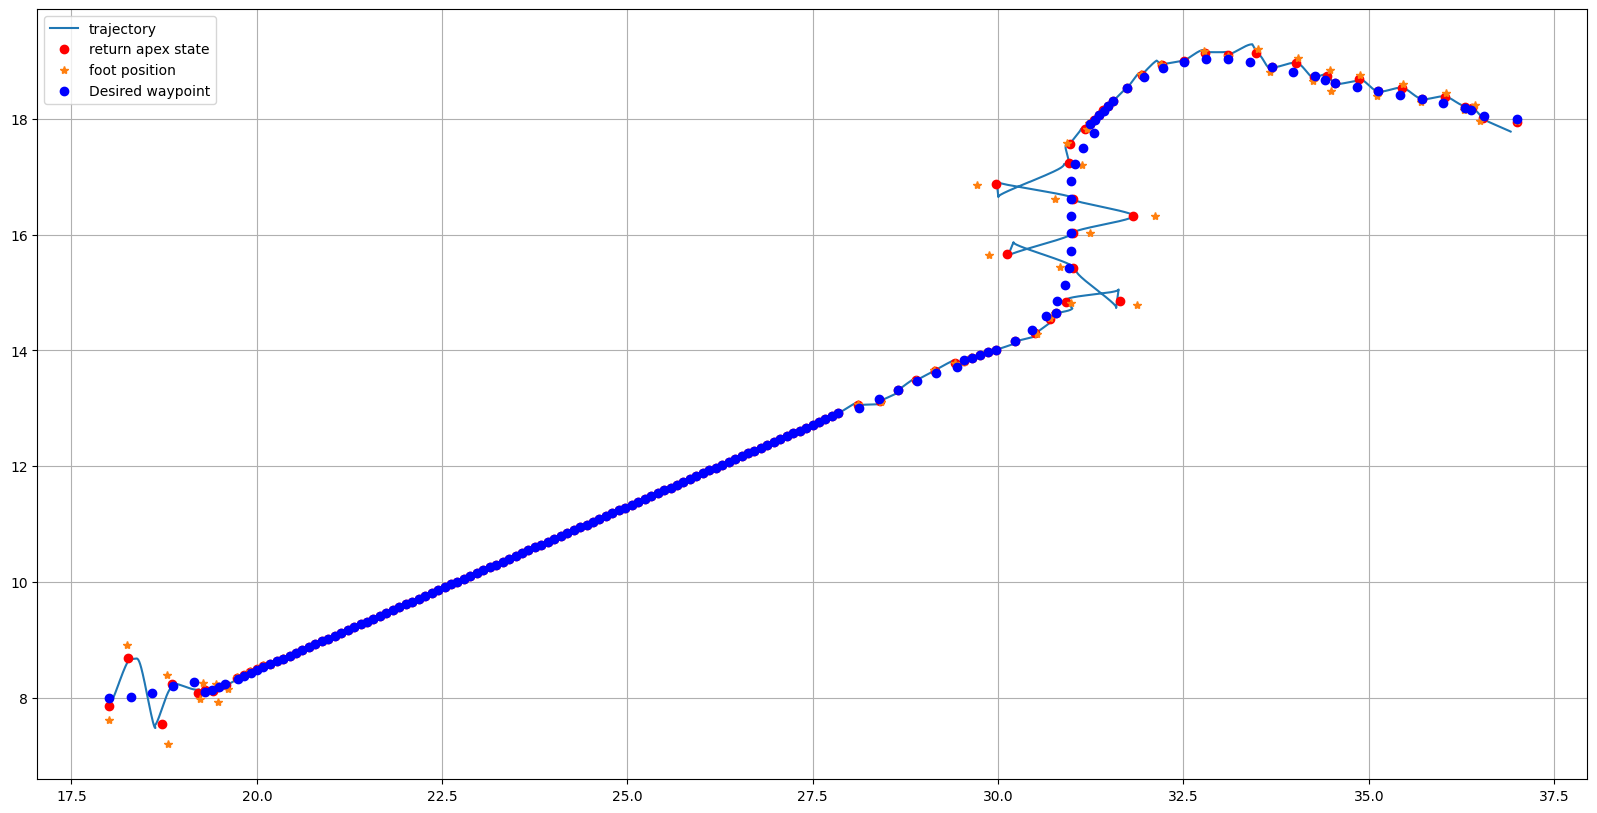

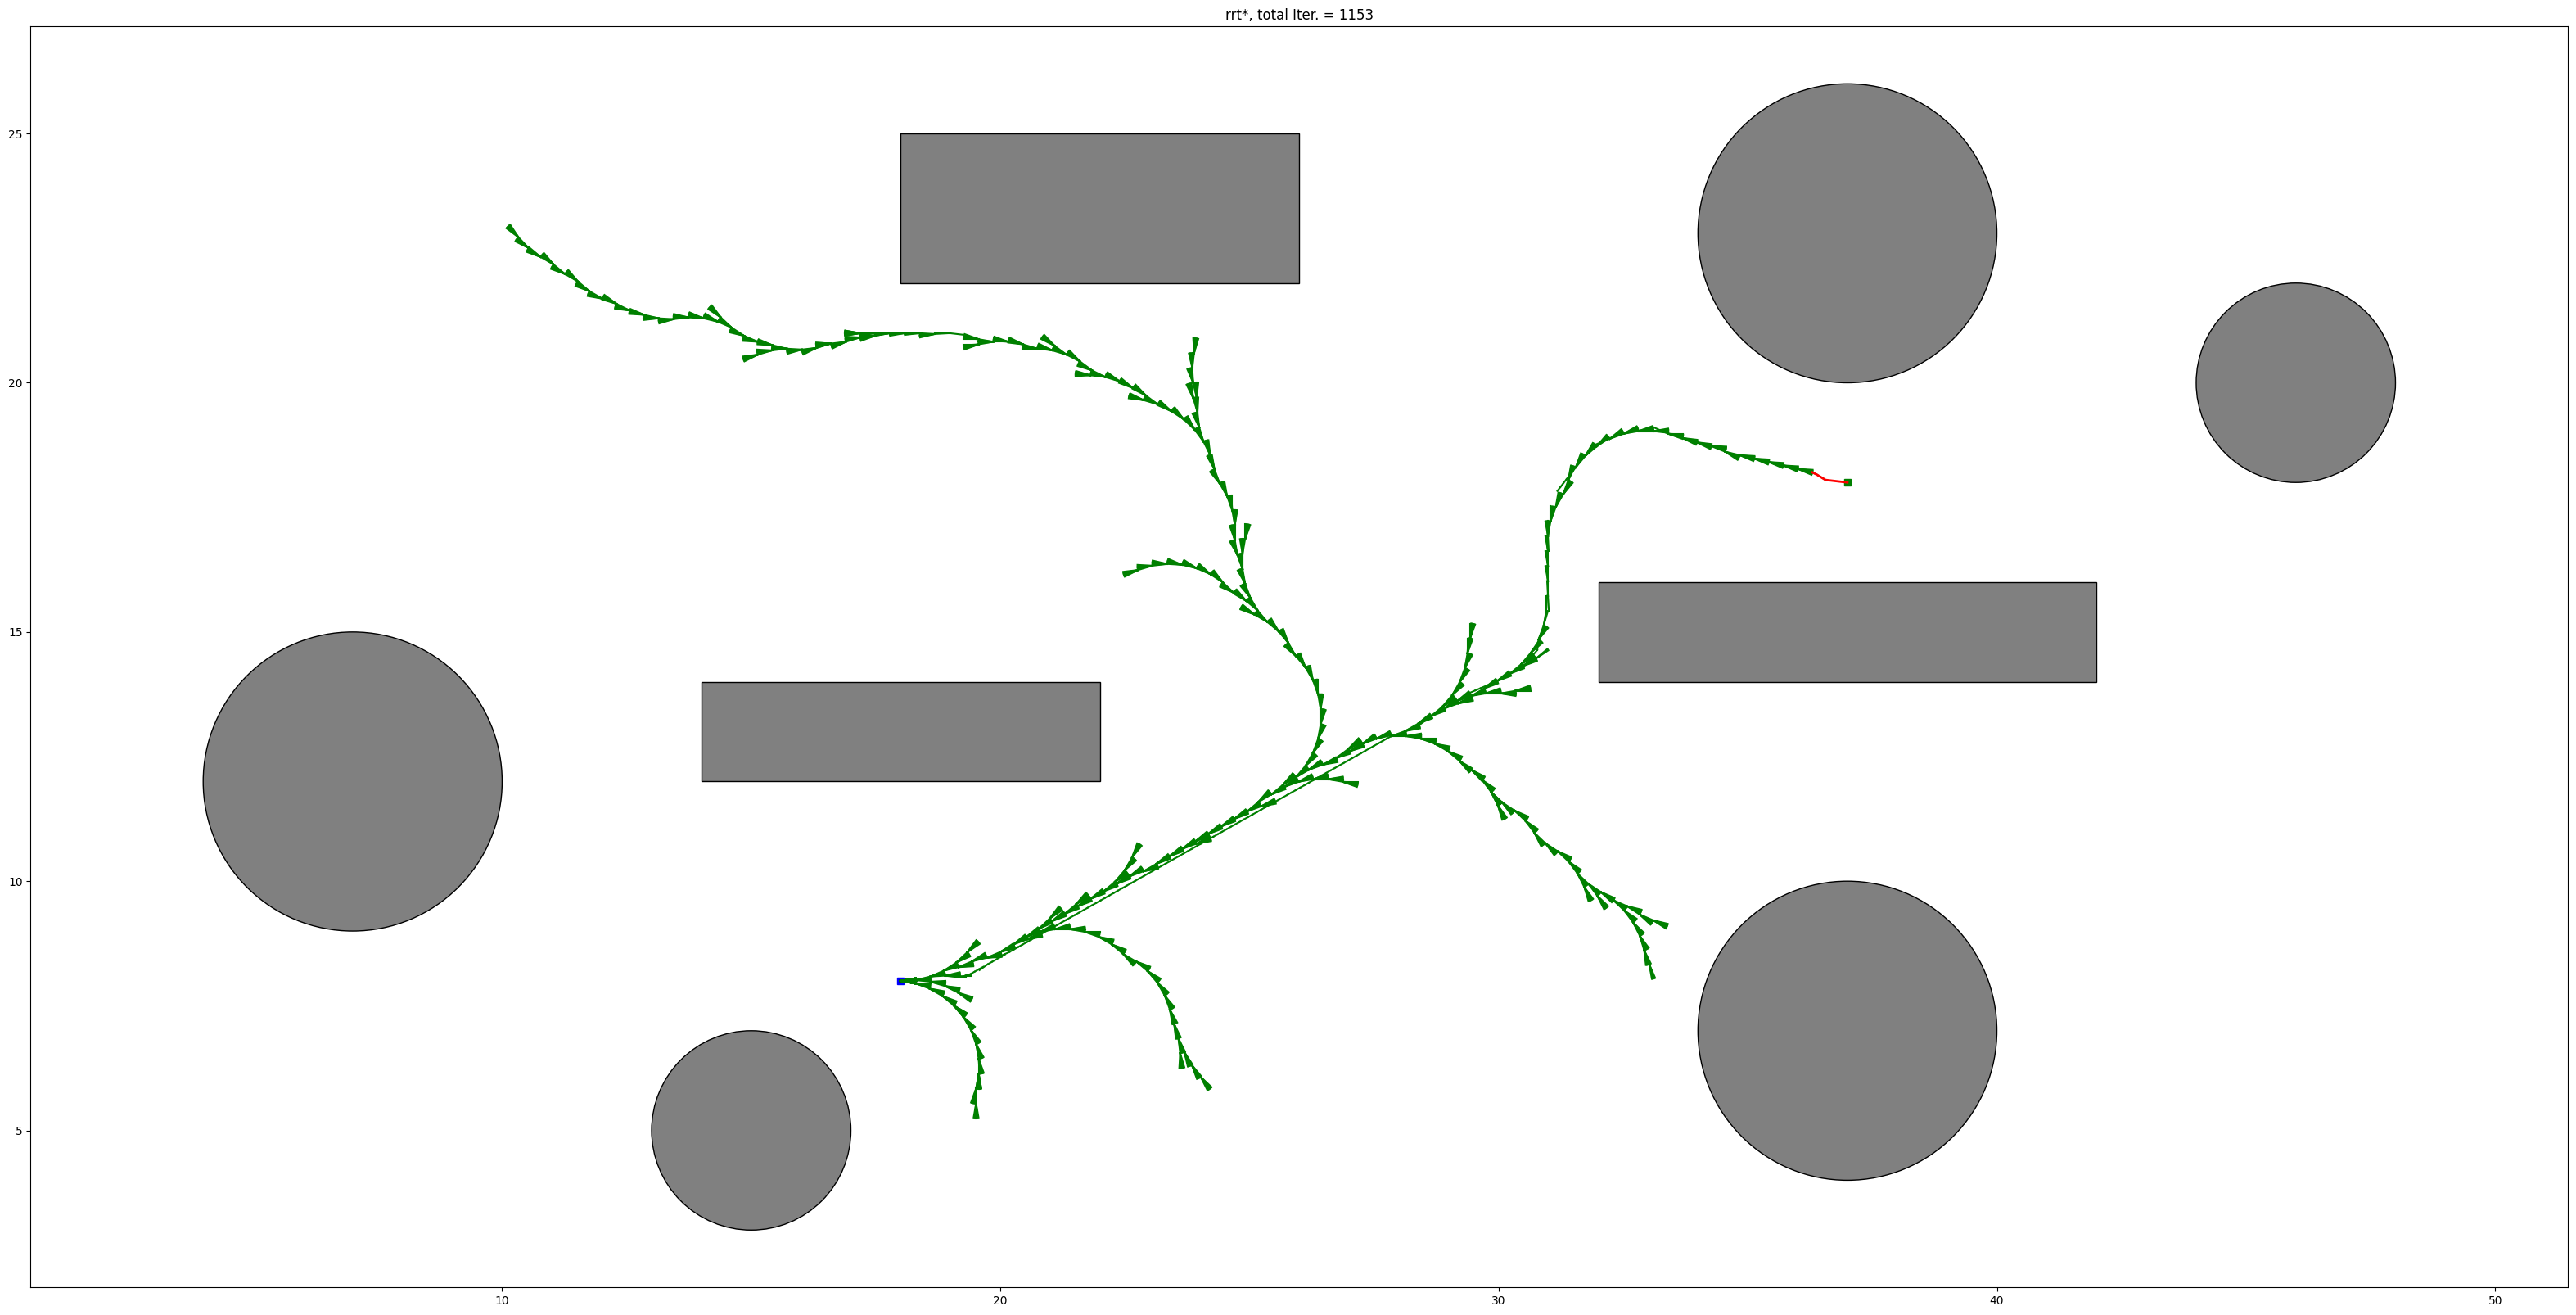

In [11]:
all_sag = np.array([])
all_lat = np.array([])
all_wp_x = np.array([])
all_wp_y = np.array([])


for i in range(len(digit.history["sagittal"])):
    
    sag = digit.history["sagittal"][i]
    lat = digit.history["lateral"][i]
    wp_x, wp_y, heading = digit.history["frame"][i]
    
    sag_global = np.array(sag) *np.cos(heading) - np.array(lat) *np.sin(heading) + wp_x
    lat_global = np.array(sag) *np.sin(heading) + np.array(lat) *np.cos(heading) + wp_y
    
    all_sag = np.append(all_sag,sag_global)
    all_lat = np.append(all_lat,lat_global)
    all_wp_x = np.append(all_wp_x,wp_x)
    all_wp_y = np.append(all_wp_y,wp_y)

plt.figure(figsize=(20,10))  
plt.plot(all_sag, all_lat, label="trajectory")
plt.plot(np.array(digit.history["apex_state"])[:,0], np.array(digit.history["apex_state"])[:,1], "or", label="return apex state")
plt.plot(np.array(digit.history["foot_position"])[:,0], np.array(digit.history["foot_position"])[:,1], "*", label="foot position")
plt.plot(np.array(digit.history["waypoint_track"])[:,0], np.array(digit.history["waypoint_track"])[:,1], "bo", label="Desired waypoint")
plt.grid()
plt.legend()


digit.plot_map()

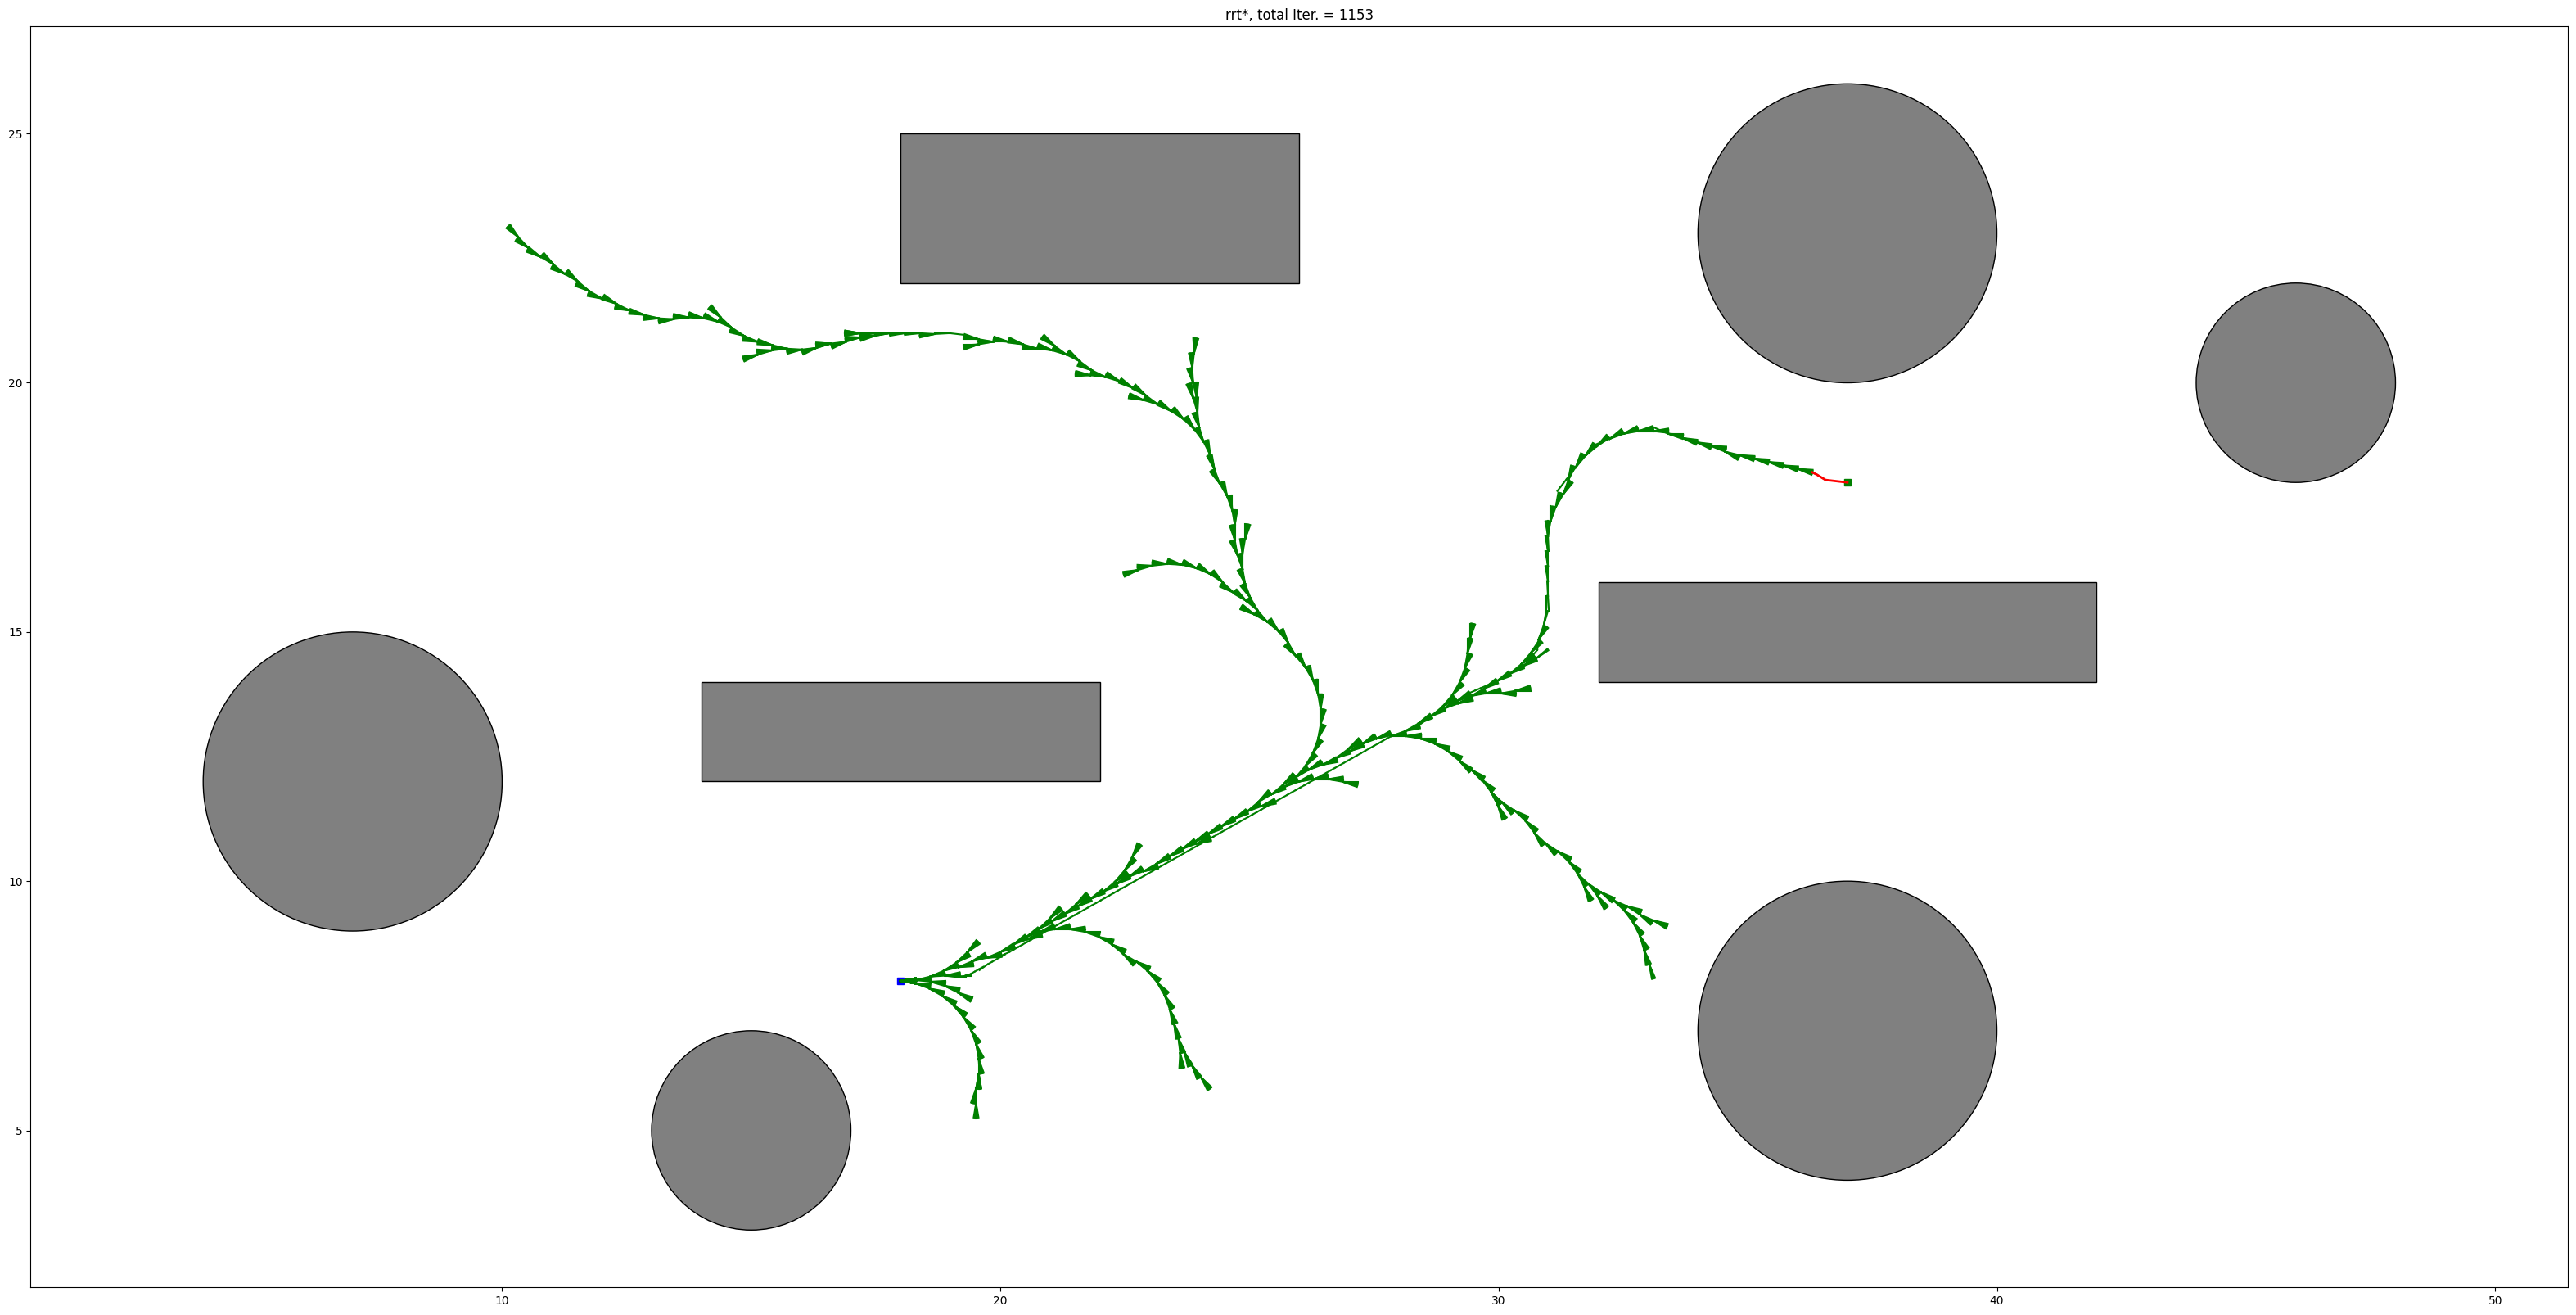

In [ ]:
current_Node =Node((digit.apex_x, digit.apex_y))

for node in digit.path_vertex:
    node.print_node_chain(show_parents=False)
    dist, theta = digit.get_distance_and_angle(current_Node, node)
    print("For Node: (" + str(node.x) + "," + str(node.y) + ")")
    print("dist: ", dist)
    print("theta: ", np.rad2deg(theta))
    print('------------------------')